# Job Description Parser & Skills Knowledge Graph Builder

## Overview
Extracts skills from job descriptions and builds a knowledge graph using association rule mining (Apriori algorithm).

## Pipeline:

**Phase 1: Data Preparation**
- Load job postings → Extract skills using tech taxonomy → Categorize job titles

**Phase 2: Skill Relationship Analysis**  
- Co-occurrence analysis → Apriori frequent itemsets → Association rules (lift, confidence)

**Phase 3: Category Analysis**
- Per-job-category skill requirements → Distinctive skills → Visualizations

**Phase 4: Knowledge Graph**
- 175 nodes (5 JobCategories, 62 Skills, 108 Skillsets)
- 1558 edges (REQUIRES, CO_OCCURS_WITH, LEADS_TO, CHARACTERISTIC_SKILLSET)

## Input/Output:
- **In**: `job_dataset.csv`, `tech_taxonomy.csv`
- **Out**: `career_skills_kg_latest.pkl` (knowledge graph)

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from collections import Counter, defaultdict
import warnings


## Setup: Import Libraries

Data processing, analysis, and visualization libraries.

In [3]:
job_scriptions = pd.read_csv('CareerPlanner/Data/job_dataset.csv')

## Phase 1: Load Job Dataset

Load job postings with titles and descriptions from CSV.

In [4]:
job_scriptions['Description'][0]

'Job Title : Python Lead Developer with AI/ML Exp.\n\nLocation : Washington DC (Onsite role)\n\nDuration : Contract (W2 role)\n\nRequired Skills: Python, Numpy, Panda with any AI (Azure, Amazon & Google but good have knowledge in Azure AI & Azure API)\n\nJob Description:\n\nRole: Lead Developer\n\nPython Programming: At least 5 years of hands-on experience with Python, particularly in\n\nframeworks like FastAPI, Django, Flask, and experience using AI frameworks.\n\n• Access Control Expertise: Strong understanding of access control models such as Role-Based\n\nAccess Control (RBAC) and Attribute-Based Access Control (ABAC).\n\n• API and Connector Development: Experience in developing API connectors using Python for\n\nextracting and managing access control data from platforms like Azure, SharePoint, Java, .NET,\n\nWordPress, etc.\n\n• AI and Machine Learning: Hands-on experience integrating AI into applications for automating\n\ntasks such as access control reviews and identifying anoma

In [5]:
"""
Match skills from tech taxonomy to job dataset and add as new column
"""

import pandas as pd
import re


def load_taxonomy(taxonomy_path):
    """Load tech taxonomy and build skill map"""
    df = pd.read_csv(taxonomy_path)
    skill_map = {}
    
    for _, row in df.iterrows():
        canonical = row['Canonical Term']
        synonyms_raw = row['Synonyms']
        
        # Add canonical term
        skill_map[canonical.lower()] = canonical
        
        # Add synonyms
        if pd.notna(synonyms_raw) and str(synonyms_raw).strip():
            synonyms = [s.strip() for s in str(synonyms_raw).split(',')]
            for syn in synonyms:
                if syn:
                    syn_clean = re.sub(r'\s*\([^)]*\)', '', syn).strip()
                    if syn_clean:
                        skill_map[syn_clean.lower()] = canonical
    
    return skill_map


def extract_skills_from_text(text, skill_map):
    """Extract all skills found in text"""
    if not text or pd.isna(text):
        return []
    
    text_lower = str(text).lower()
    found_skills = []
    
    # Sort by length to match longer phrases first
    sorted_terms = sorted(skill_map.keys(), key=len, reverse=True)
    
    for term in sorted_terms:
        escaped_term = re.escape(term)
        
        # Handle special characters like .NET, C#
        if '.' in term or '#' in term:
            pattern = escaped_term
        else:
            pattern = r'\b' + escaped_term + r'\b'
        
        if re.search(pattern, text_lower, re.IGNORECASE):
            canonical = skill_map[term]
            if canonical not in found_skills:
                found_skills.append(canonical)
    
    return found_skills


def process_job_dataset(jobs_csv, taxonomy_csv, output_csv):
    """
    Process job dataset and add matched skills column
    
    Args:
        jobs_csv: Path to job_dataset.csv
        taxonomy_csv: Path to tech_taxonomy.csv
        output_csv: Path for output file
    """
    print("Loading data...")
    
    # Load jobs
    jobs_df = pd.read_csv(jobs_csv)
    print(f"Loaded {len(jobs_df)} jobs")
    print(f"Columns: {jobs_df.columns.tolist()}")
    
    # Load taxonomy
    skill_map = load_taxonomy(taxonomy_csv)
    print(f"Loaded {len(skill_map)} skill terms from taxonomy")
    
    # Extract skills from Description column
    print("\nExtracting skills from descriptions...")
    jobs_df['matched_skills'] = jobs_df['Description'].apply(
        lambda text: extract_skills_from_text(text, skill_map)
    )
    
    # Add skill count
    jobs_df['matched_skill_count'] = jobs_df['matched_skills'].apply(len)
    
    # Convert list to pipe-separated string for easier viewing in CSV
    jobs_df['matched_skills_text'] = jobs_df['matched_skills'].apply(
        lambda skills: '|'.join(skills) if skills else ''
    )
    
    # Save result
    # jobs_df.to_csv(output_csv, index=False)
    # print(f"\nSaved results to: {output_csv}")
    
    # # Print summary
    # print("\n" + "="*80)
    # print("SUMMARY")
    # print("="*80)
    # print(f"Total jobs processed: {len(jobs_df)}")
    # print(f"Jobs with skills found: {(jobs_df['matched_skill_count'] > 0).sum()}")
    # print(f"Average skills per job: {jobs_df['matched_skill_count'].mean():.1f}")
    # print(f"Max skills in one job: {jobs_df['matched_skill_count'].max()}")
    
    # print("\nTop 10 most common skills:")
    # all_skills = []
    # for skills in jobs_df['matched_skills']:
    #     all_skills.extend(skills)
    
    # skill_counts = pd.Series(all_skills).value_counts().head(10)
    # for skill, count in skill_counts.items():
    #     print(f"  {skill}: {count} jobs")
    
    # print("\nSample results:")
    print(jobs_df[['Job Title', 'matched_skill_count', 'matched_skills_text']].head())
    
    return jobs_df




### Skill Extraction from Descriptions

Match tech taxonomy skills to job descriptions using regex. Handles synonyms (e.g., "JS" → "JavaScript").

In [6]:

result_df = process_job_dataset(
jobs_csv='CareerPlanner/Data/job_dataset.csv',
taxonomy_csv='CareerPlanner/Data/tech_taxonomy.csv',
output_csv='CareerPlanner/Data/result.csv'
)

Loading data...
Loaded 49 jobs
Columns: ['Job Title', 'Company', 'Location', 'Description', 'Skill']
Loaded 165 skill terms from taxonomy

Extracting skills from descriptions...
                                   Job Title  matched_skill_count  \
0  W2 Role: Python Lead Developer with AI/ML                   13   
1            Python Senior Software Engineer                   13   
2                Python Developer II (11412)                   12   
3                Python/R Programmer - Entry                    8   
4             Python Developer (Entry Level)                    9   

                                 matched_skills_text  
0  CI/CD|Power BI|FastAPI|Python|Django|Pandas|Fl...  
1  JavaScript|Bootstrap|Angular|Python|Spring|Rea...  
2  JavaScript|Kubernetes|Python|Django|Docker|She...  
3  Spring|JavaScript|Jenkins|Python|Docker|GitHub...  
4  Spring|JavaScript|TensorFlow|Jenkins|Tableau|P...  


In [7]:
result_df

Job Title  \
0           W2 Role: Python Lead Developer with AI/ML   
1                     Python Senior Software Engineer   
2                         Python Developer II (11412)   
3                         Python/R Programmer - Entry   
4                      Python Developer (Entry Level)   
5     Software Developer (Full Stack - Python, React)   
6                                   Python Programmer   
7                             Senior Python Developer   
8             Senior Software Engineer (Python & AWS)   
9                 React Developer (Always Recruiting)   
10                        Front End - React Developer   
11        Senior Full Stack React Developer (On-Site)   
12                Application Developer (React & SQL)   
13                                    React Developer   
14                  Front End Developer with React JS   
15                                 React.js Developer   
16  Junior Front End React Developer (TS/SCI with ...   
17                                    React Developer   
18                          React Front End Developer   
19  Delivery Consultant - Cloud Infrastructure, Pr...   
20  Labor & Workforce - Business Development Manag...   
21  Principal, AWS Global AI Public Policy, AWS Gl...   
22  Senior Applied Scientist, AWS Vulnerability Ma...   
23                 Technical Program Manager, AWS T&C   
24  Principal Solutions Architect, Capital Markets...   
25                            Specialist SA, GenAI/ML   
26  Enterprise Account Executive, AWS Not-for-Prof...   
27  Principal TAM, AWS Enterprise Support, Strateg...   
28                     Electrical Design Eng-HOH 25-3   
29           Senior SQL Server Database Administrator   
30                             Database SQL Developer   
31                           Database Specialist Jobs   
32                Application Developer (React & SQL)   
33               Mid Level Data Engineer (python/SQL)   
34                           Database and BI Engineer   
35                                            SQL DBA   
36                         SQL Database Administrator   
37                                            SQL DBA   
38              Lead Data Engineer (Python, SQL, AWS)   
39  AWS Java Full Stack Architect - Washington, DC...   
40     Senior Full Stack Java Developer AWS and Kafka   
41              Full Stack Developer (Angular & Java)   
42                           Java Fullstack developer   
43                      AWS Java Full Stack Developer   
44                          Full Stack Java Developer   
45                       Software Developer II – Java   
46                      AWS Java Full Stack Developer   
47                      Senior Backend Java Developer   
48  AWS Java Full Stack Developer at Signature IT ...   

                                    Company            Location  \
0                                   Yochana          Washington   
1                                   Walmart          Washington   
2         Inabia Software & Consulting Inc.          Washington   
3                             SynergisticIT          Washington   
4                             SynergisticIT          Washington   
5              US News & World Report ,L.P.          Washington   
6                             SynergisticIT          Washington   
7                             Zachary Piper           Arlington   
8                               Freddie Mac              McLean   
9                Dev Technology Group, Inc.          Washington   
10                 Anagh Technologies, Inc.          Washington   
11                             Lion Federal        Falls Church   
12                     VivSoft Technologies           Arlington   
13                            Agile Defense                 NaN   
14                              Humana Inc.          Washington   
15                         Omm IT Solutions       Silver Spring   
16  General Dynamics Information Technology  Annapolis

In [8]:
"""
Job Title Categorization Mapper
Maps job titles to standardized buckets
"""

import re


def create_job_title_mapper():
    """
    Create mapping rules for job titles to standard categories
    
    Returns:
        dict: Category -> list of keywords/patterns
    """
    job_categories = {
        'ML/AI Engineer': [
            'machine learning', 'ml engineer', 'ai engineer',
            'artificial intelligence', 'deep learning', 'nlp',
            'data scientist', 'computer vision', 'llm'
        ],
        'Backend Engineer': [
            'backend', 'back-end', 'api', 'microservices',
            'server', 'backend developer', 'backend engineer'
        ],
        'Frontend Engineer': [
            'frontend', 'front-end', 'ui', 'ux',
            'react', 'angular', 'vue', 'web developer',
            'frontend developer', 'frontend engineer'
        ],
        'FullStack Engineer': [
            'full stack', 'fullstack', 'full-stack',
            'fullstack developer', 'full stack developer'
        ],
        'Software Engineer': [
            'software engineer', 'software developer',
            'developer', 'engineer', 'programmer',
            'python developer', 'java developer', '.net developer'
        ]
    }
    
    return job_categories


def categorize_job_title(job_title, job_description=''):
    """
    Categorize a job title into one of the standard buckets
    
    Priority order:
    1. ML/AI Engineer (most specific)
    2. FullStack Engineer
    3. Backend Engineer
    4. Frontend Engineer
    5. Software Engineer (most general, fallback)
    
    Args:
        job_title: Job title string
        job_description: Optional job description for additional context
    
    Returns:
        str: Category name
    """
    if not job_title or pd.isna(job_title):
        return 'Software Engineer'
    
    # Combine title and description for better matching
    combined_text = (str(job_title) + ' ' + str(job_description)).lower()
    
    categories = create_job_title_mapper()
    
    # Score each category
    scores = {}
    for category, keywords in categories.items():
        score = 0
        for keyword in keywords:
            pattern = r'\b' + re.escape(keyword) + r'\b'
            matches = len(re.findall(pattern, combined_text))
            score += matches
        scores[category] = score
    
    # Priority-based selection (with tie-breaking)
    priority_order = [
        'ML/AI Engineer',
        'FullStack Engineer',
        'Backend Engineer',
        'Frontend Engineer',
        'Software Engineer'
    ]
    
    # Find category with highest score
    max_score = max(scores.values())
    
    if max_score == 0:
        return 'Software Engineer'  # Default fallback
    
    # Return highest priority category with max score
    for category in priority_order:
        if scores[category] == max_score:
            return category
    
    return 'Software Engineer'


def add_job_category_column(jobs_df, title_col='Job Title', desc_col='Description'):
    """
    Add job_category column to dataframe
    
    Args:
        jobs_df: DataFrame with job data
        title_col: Name of job title column
        desc_col: Name of description column (optional)
    
    Returns:
        DataFrame with new job_category column
    """
    print(f"Categorizing {len(jobs_df)} jobs...")
    
    # Apply categorization
    if desc_col in jobs_df.columns:
        jobs_df['job_category'] = jobs_df.apply(
            lambda row: categorize_job_title(row[title_col], row[desc_col]),
            axis=1
        )
    else:
        jobs_df['job_category'] = jobs_df[title_col].apply(
            lambda title: categorize_job_title(title)
        )
    
    # Print distribution
    print("\nJob Category Distribution:")
    print("="*60)
    category_counts = jobs_df['job_category'].value_counts()
    for category, count in category_counts.items():
        percentage = (count / len(jobs_df)) * 100
        print(f"{category:25s}: {count:3d} ({percentage:5.1f}%)")
    print("="*60)
    
    return jobs_df

### Job Title Categorization

Standardize job titles into 5 categories: Backend Engineer, Frontend Engineer, ML/AI Engineer, Software Engineer, Data Engineer.

In [9]:
# Apply job categorization to the result dataframe
result_df_categorized = add_job_category_column(result_df)

# Show sample results
print("\nSample Results:")
print(result_df_categorized[['Job Title', 'job_category', 'matched_skill_count']].head(10))

Categorizing 49 jobs...

Job Category Distribution:
Software Engineer        :  18 ( 36.7%)
Frontend Engineer        :   9 ( 18.4%)
Backend Engineer         :   8 ( 16.3%)
ML/AI Engineer           :   8 ( 16.3%)
FullStack Engineer       :   6 ( 12.2%)

Sample Results:
                                         Job Title       job_category  \
0        W2 Role: Python Lead Developer with AI/ML   Backend Engineer   
1                  Python Senior Software Engineer  Frontend Engineer   
2                      Python Developer II (11412)  Software Engineer   
3                      Python/R Programmer - Entry     ML/AI Engineer   
4                   Python Developer (Entry Level)     ML/AI Engineer   
5  Software Developer (Full Stack - Python, React)  Software Engineer   
6                                Python Programmer     ML/AI Engineer   
7                          Senior Python Developer  Software Engineer   
8          Senior Software Engineer (Python & AWS)  Software Engineer   
9

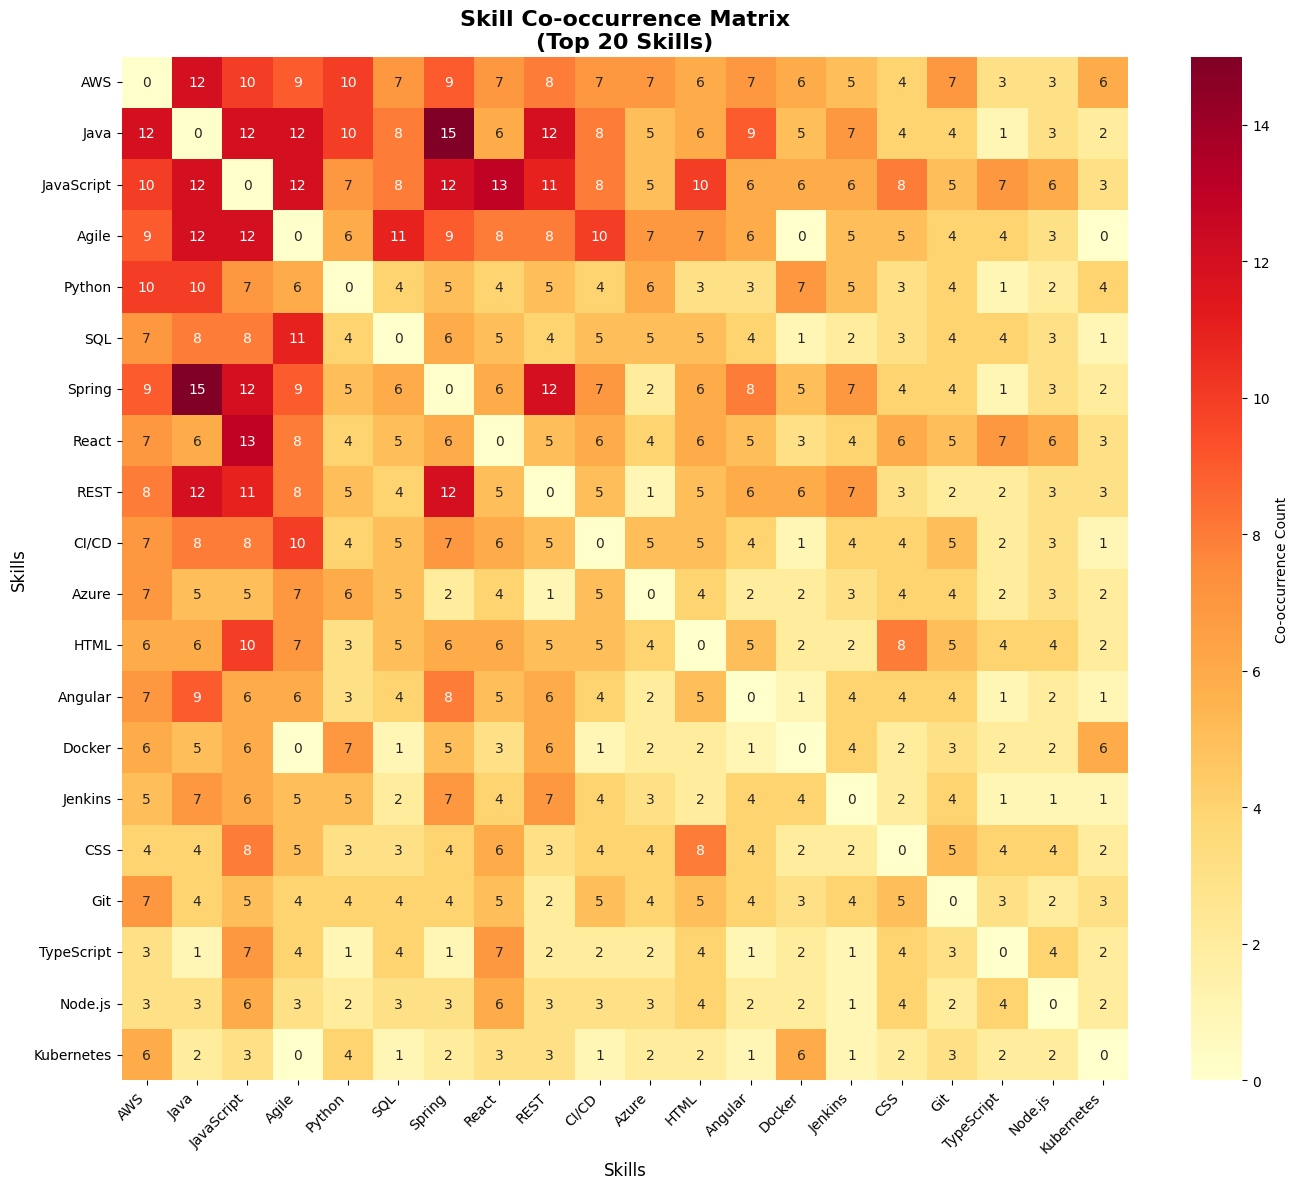


Top 10 Most Frequently Occurring Skills:
  AWS                      : 27 jobs (55.1%)
  Java                     : 21 jobs (42.9%)
  JavaScript               : 21 jobs (42.9%)
  Agile                    : 20 jobs (40.8%)
  Python                   : 18 jobs (36.7%)
  SQL                      : 18 jobs (36.7%)
  Spring                   : 15 jobs (30.6%)
  React                    : 15 jobs (30.6%)
  REST                     : 14 jobs (28.6%)
  CI/CD                    : 11 jobs (22.4%)


In [10]:
"""
1. SKILL CO-OCCURRENCE MATRIX
Shows which skills appear together in job postings
"""

def build_cooccurrence_matrix(df, top_n=20):
    """Build co-occurrence matrix for top N skills"""
    
    # Get top N most common skills
    all_skills = []
    for skills in df['matched_skills']:
        all_skills.extend(skills)
    
    skill_counts = Counter(all_skills)
    top_skills = [skill for skill, _ in skill_counts.most_common(top_n)]
    
    # Build co-occurrence matrix
    cooccur = defaultdict(lambda: defaultdict(int))
    
    for skills in df['matched_skills']:
        for skill1, skill2 in combinations(skills, 2):
            if skill1 in top_skills and skill2 in top_skills:
                cooccur[skill1][skill2] += 1
                cooccur[skill2][skill1] += 1
    
    # Convert to matrix
    matrix = np.zeros((len(top_skills), len(top_skills)))
    for i, skill1 in enumerate(top_skills):
        for j, skill2 in enumerate(top_skills):
            matrix[i][j] = cooccur[skill1][skill2]
    
    return matrix, top_skills


# Build and visualize co-occurrence matrix
matrix, top_skills = build_cooccurrence_matrix(result_df_categorized, top_n=20)

plt.figure(figsize=(14, 12))
sns.heatmap(matrix, 
            xticklabels=top_skills, 
            yticklabels=top_skills,
            cmap='YlOrRd',
            annot=True,
            fmt='.0f',
            cbar_kws={'label': 'Co-occurrence Count'})
plt.title('Skill Co-occurrence Matrix\n(Top 20 Skills)', fontsize=16, fontweight='bold')
plt.xlabel('Skills', fontsize=12)
plt.ylabel('Skills', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\nTop 10 Most Frequently Occurring Skills:")
skill_freq = Counter([skill for skills in result_df_categorized['matched_skills'] for skill in skills])
for skill, count in skill_freq.most_common(10):
    print(f"  {skill:25s}: {count:2d} jobs ({count/len(result_df_categorized)*100:.1f}%)")

## Phase 2: Skill Relationship Analysis

Analyze which skills appear together using co-occurrence, frequent itemsets (Apriori), and association rules.

In [11]:
"""
2. FREQUENT ITEMSETS ANALYSIS (GENERIC)
Find which skill combinations appear most frequently together
"""

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

def find_frequent_itemsets(df, min_support=0.10, max_length=None, top_n_per_length=15):
    """
    Generic function to find frequent itemsets

    Parameters:
    -----------
    df : DataFrame with matched_skills column
    min_support : float, minimum support threshold (0-1)
    max_length : int or None, maximum itemset size to consider
    top_n_per_length : int, how many top itemsets to show per length

    Returns:
    --------
    DataFrame with frequent itemsets
    """
    # Prepare data for itemset mining
    transactions = df['matched_skills'].tolist()

    # Convert to one-hot encoded dataframe
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # Find frequent itemsets
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

    if max_length:
        frequent_itemsets = frequent_itemsets[frequent_itemsets['length'] <= max_length]

    frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)

    return frequent_itemsets


def display_itemsets(itemsets, df, top_n_per_length=15):
    """Display itemsets grouped by length"""

    total_jobs = len(df)

    print("="*80)
    print(f"FREQUENT SKILL ITEMSETS (min_support={itemsets['support'].min():.2f})")
    print("="*80)

    # Group by length and display
    for length in sorted(itemsets['length'].unique()):
        length_itemsets = itemsets[itemsets['length'] == length].head(top_n_per_length)

        if len(length_itemsets) == 0:
            continue

        # Generic label based on length
        print(f"\n--- {length}-Skill Itemsets (Top {min(top_n_per_length, len(length_itemsets))}) ---")

        for idx, row in length_itemsets.iterrows():
            skills = sorted(list(row['itemsets']))
            support_pct = row['support'] * 100
            count = int(row['support'] * total_jobs)

            skill_str = ', '.join(skills)
            print(f"  {skill_str:65s} | {support_pct:5.1f}% ({count}/{total_jobs} jobs)")


# Run analysis with configurable parameters
frequent_itemsets = find_frequent_itemsets(
    result_df_categorized,
    min_support=0.10,      # Adjust threshold
    max_length=5,          # Look at itemsets up to size 5
    top_n_per_length=15    # Show top 15 per length
)

display_itemsets(frequent_itemsets, result_df_categorized, top_n_per_length=15)

FREQUENT SKILL ITEMSETS (min_support=0.10)

--- 1-Skill Itemsets (Top 15) ---
  AWS                                                               |  55.1% (26/49 jobs)
  JavaScript                                                        |  42.9% (21/49 jobs)
  Java                                                              |  42.9% (21/49 jobs)
  Agile                                                             |  40.8% (20/49 jobs)
  SQL                                                               |  36.7% (18/49 jobs)
  Python                                                            |  36.7% (18/49 jobs)
  Spring                                                            |  30.6% (15/49 jobs)
  React                                                             |  30.6% (15/49 jobs)
  REST                                                              |  28.6% (14/49 jobs)
  CI/CD                                                             |  22.4% (11/49 jobs)
  Azure               

SKILL ASSOCIATION RULES

Top 20 Rules (sorted by lift)
Lift > 1 means skills appear together more often than expected by chance
--------------------------------------------------------------------------------

IF: Kubernetes
THEN: Docker, AWS
  Confidence: 100.0% | Lift: 8.17 | Support: 12.2%

IF: Docker, AWS
THEN: Kubernetes
  Confidence: 100.0% | Lift: 8.17 | Support: 12.2%

IF: JavaScript, Angular
THEN: Spring, HTML, Java
  Confidence: 83.3% | Lift: 6.81 | Support: 10.2%

IF: JavaScript, Angular, Java
THEN: Spring, HTML
  Confidence: 83.3% | Lift: 6.81 | Support: 10.2%

IF: HTML, Java
THEN: JavaScript, Angular
  Confidence: 83.3% | Lift: 6.81 | Support: 10.2%

IF: JavaScript, Angular
THEN: HTML, Java
  Confidence: 83.3% | Lift: 6.81 | Support: 10.2%

IF: JavaScript, Angular
THEN: Spring, HTML
  Confidence: 83.3% | Lift: 6.81 | Support: 10.2%

IF: Spring, HTML
THEN: JavaScript, Angular
  Confidence: 83.3% | Lift: 6.81 | Support: 10.2%

IF: JavaScript, Spring, Angular
THEN: HTML, Java

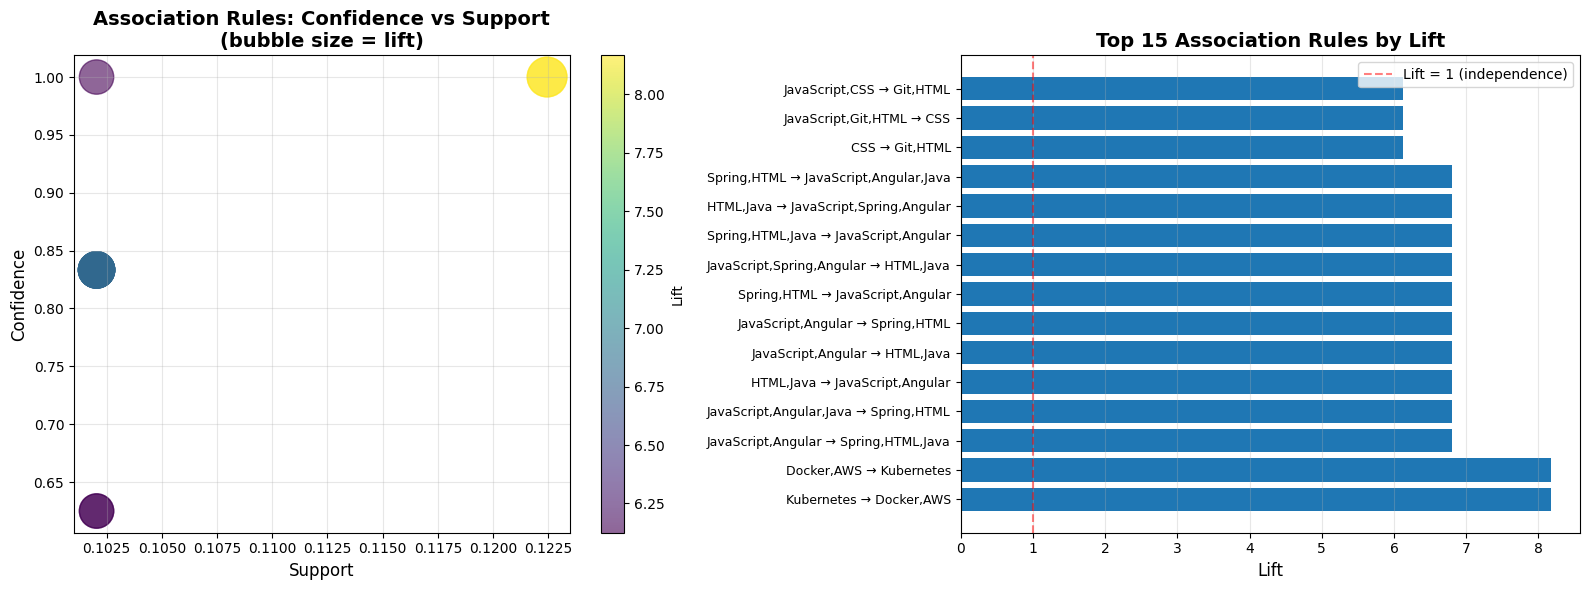

In [12]:
"""
3. ASSOCIATION RULES
Find rules like: "If job requires skill A, it likely also requires skill B"
Useful for understanding skill dependencies
"""

# Generate association rules from frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules = rules.sort_values('lift', ascending=False)

print("="*80)
print("SKILL ASSOCIATION RULES")
print("="*80)
print("\nTop 20 Rules (sorted by lift)")
print("Lift > 1 means skills appear together more often than expected by chance")
print("-"*80)

for idx, rule in rules.head(20).iterrows():
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    conf = rule['confidence'] * 100
    lift = rule['lift']
    supp = rule['support'] * 100
    
    print(f"\nIF: {antecedents}")
    print(f"THEN: {consequents}")
    print(f"  Confidence: {conf:.1f}% | Lift: {lift:.2f} | Support: {supp:.1f}%")

# Visualize top rules
top_rules = rules.head(15)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confidence vs Support
scatter = ax1.scatter(top_rules['support'], 
                      top_rules['confidence'],
                      s=top_rules['lift']*100,
                      c=top_rules['lift'],
                      cmap='viridis',
                      alpha=0.6)
ax1.set_xlabel('Support', fontsize=12)
ax1.set_ylabel('Confidence', fontsize=12)
ax1.set_title('Association Rules: Confidence vs Support\n(bubble size = lift)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Lift')

# Plot 2: Lift distribution
ax2.barh(range(len(top_rules)), top_rules['lift'].values)
rule_labels = [f"{','.join(list(r['antecedents']))} → {','.join(list(r['consequents']))}" 
               for _, r in top_rules.iterrows()]
ax2.set_yticks(range(len(top_rules)))
ax2.set_yticklabels([label[:40] + '...' if len(label) > 40 else label for label in rule_labels], fontsize=9)
ax2.set_xlabel('Lift', fontsize=12)
ax2.set_title('Top 15 Association Rules by Lift', fontsize=14, fontweight='bold')
ax2.axvline(x=1, color='red', linestyle='--', alpha=0.5, label='Lift = 1 (independence)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

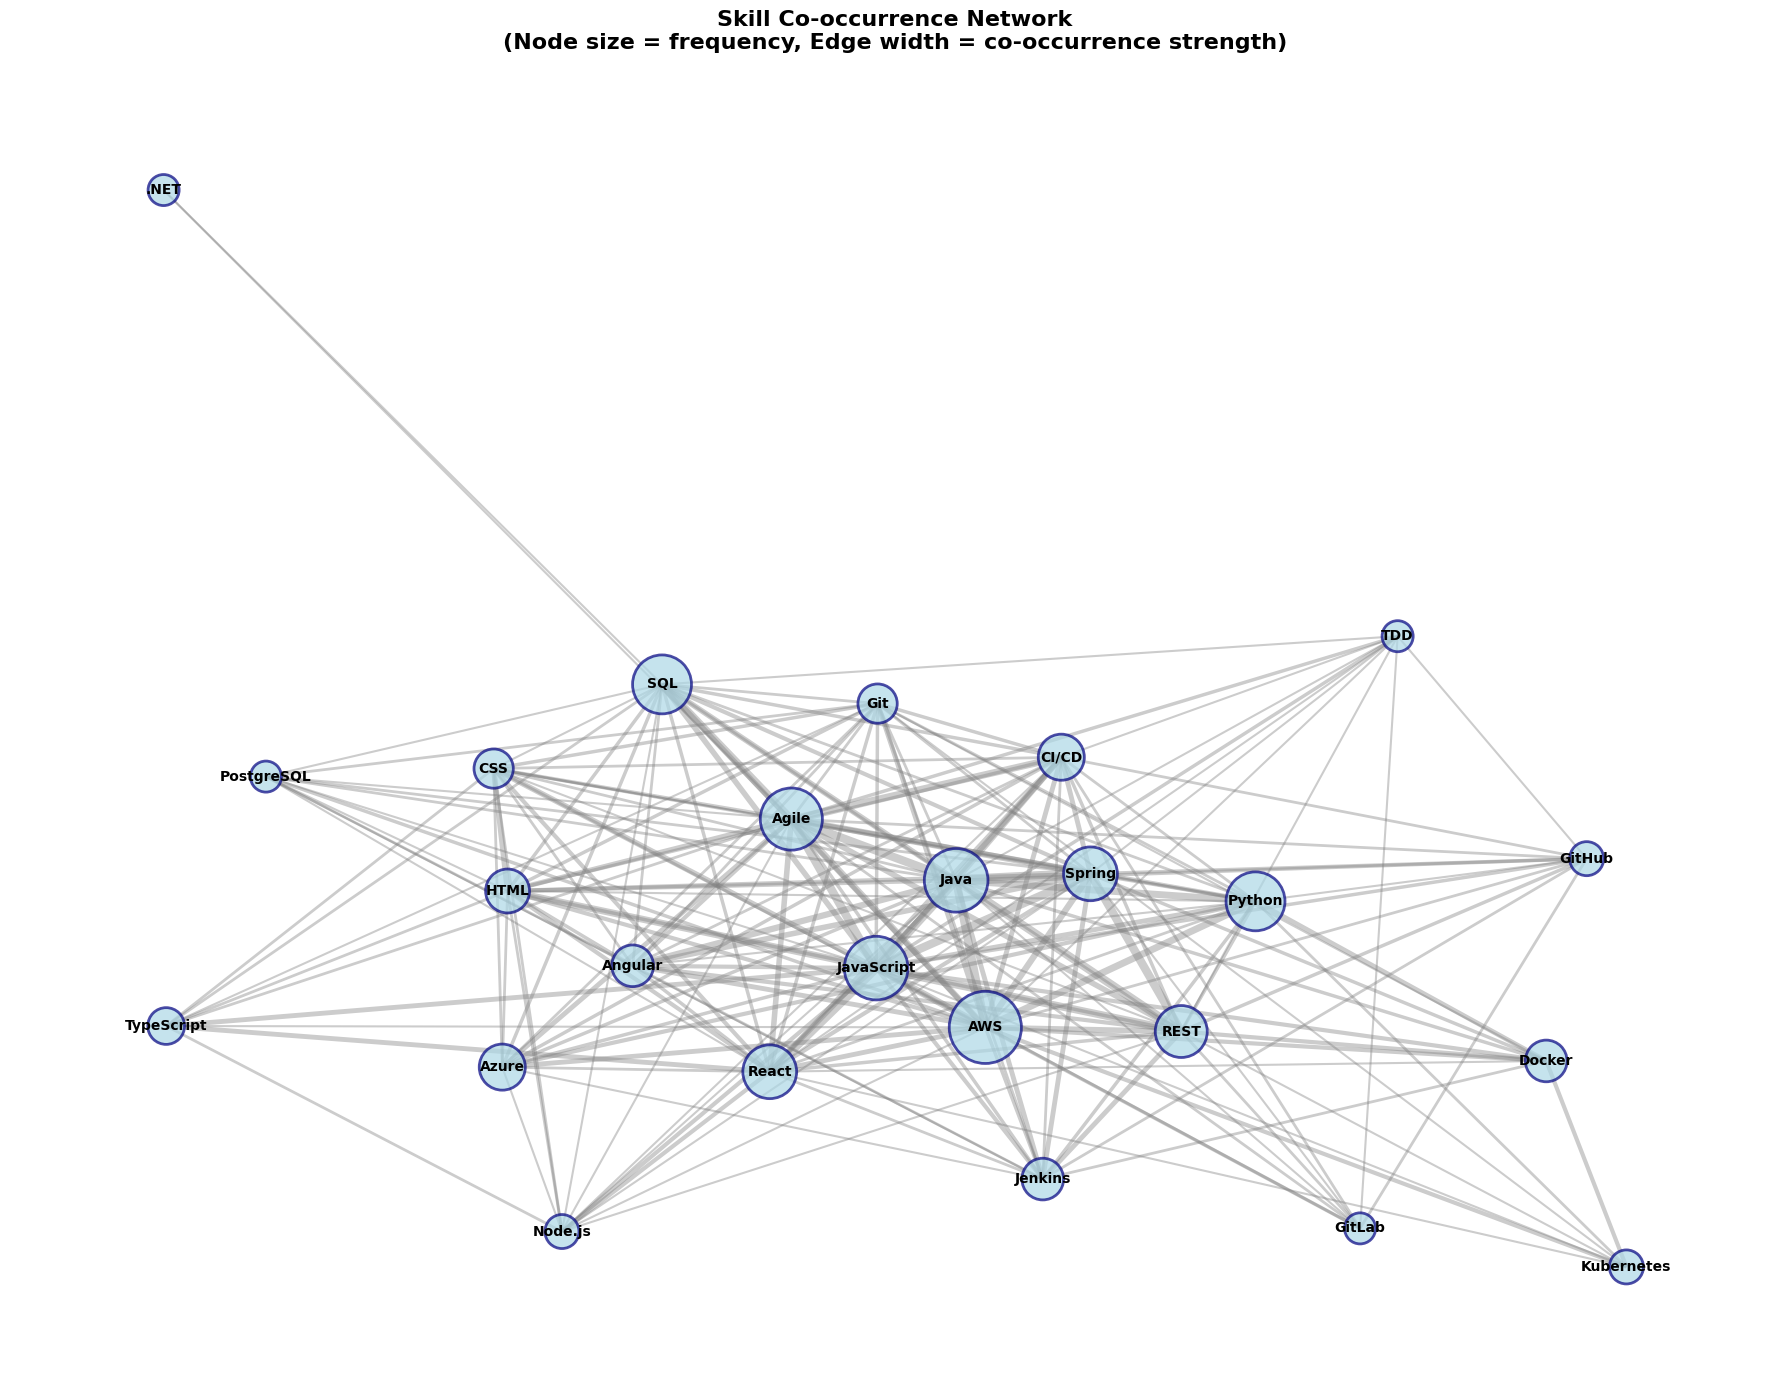


NETWORK STATISTICS
Number of skills (nodes): 25
Number of connections (edges): 191
Network density: 0.637

--- Most Central Skills (by degree centrality) ---
  JavaScript               : 0.958 (connected to 23 other skills)
  AWS                      : 0.958 (connected to 23 other skills)
  Agile                    : 0.917 (connected to 22 other skills)
  Java                     : 0.875 (connected to 21 other skills)
  React                    : 0.875 (connected to 21 other skills)
  Spring                   : 0.833 (connected to 20 other skills)
  CI/CD                    : 0.792 (connected to 19 other skills)
  REST                     : 0.792 (connected to 19 other skills)
  SQL                      : 0.792 (connected to 19 other skills)
  Python                   : 0.750 (connected to 18 other skills)


In [13]:
"""
4. NETWORK GRAPH OF SKILL RELATIONSHIPS
Visualize skills as a network where edges represent co-occurrence
"""

import networkx as nx

def build_skill_network(df, min_cooccurrence=3, top_n=25):
    """Build network graph from skill co-occurrences"""
    
    # Get top N skills
    all_skills = []
    for skills in df['matched_skills']:
        all_skills.extend(skills)
    skill_counts = Counter(all_skills)
    top_skills = set([skill for skill, _ in skill_counts.most_common(top_n)])
    
    # Build graph
    G = nx.Graph()
    
    # Add edges based on co-occurrence
    for skills in df['matched_skills']:
        filtered_skills = [s for s in skills if s in top_skills]
        for skill1, skill2 in combinations(filtered_skills, 2):
            if G.has_edge(skill1, skill2):
                G[skill1][skill2]['weight'] += 1
            else:
                G.add_edge(skill1, skill2, weight=1)
    
    # Filter edges by minimum co-occurrence
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_cooccurrence]
    G.remove_edges_from(edges_to_remove)
    
    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))
    
    # Add node attributes (degree centrality and frequency)
    for node in G.nodes():
        G.nodes[node]['frequency'] = skill_counts[node]
        G.nodes[node]['degree'] = G.degree(node)
    
    return G, skill_counts


# Build network
G, skill_counts = build_skill_network(result_df_categorized, min_cooccurrence=3, top_n=25)

# Calculate layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Prepare visualization
plt.figure(figsize=(18, 14))

# Node sizes based on frequency
node_sizes = [skill_counts[node] * 100 for node in G.nodes()]

# Edge widths based on co-occurrence
edge_widths = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]

# Draw network
nx.draw_networkx_nodes(G, pos, 
                       node_size=node_sizes,
                       node_color='lightblue',
                       alpha=0.7,
                       edgecolors='navy',
                       linewidths=2)

nx.draw_networkx_edges(G, pos,
                       width=edge_widths,
                       alpha=0.4,
                       edge_color='gray')

nx.draw_networkx_labels(G, pos,
                        font_size=10,
                        font_weight='bold',
                        font_family='sans-serif')

plt.title('Skill Co-occurrence Network\n(Node size = frequency, Edge width = co-occurrence strength)', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print network statistics
print("\n" + "="*80)
print("NETWORK STATISTICS")
print("="*80)
print(f"Number of skills (nodes): {G.number_of_nodes()}")
print(f"Number of connections (edges): {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.3f}")

print("\n--- Most Central Skills (by degree centrality) ---")
centrality = nx.degree_centrality(G)
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for skill, cent in sorted_centrality:
    print(f"  {skill:25s}: {cent:.3f} (connected to {G.degree(skill)} other skills)")

In [14]:
"""
5. JOB CATEGORY → SKILLS RELATIONSHIPS
Understand which skills are most common for each job category
"""

def analyze_skills_by_category(df):
    """Analyze skill distribution across job categories"""
    
    category_skills = {}
    
    for category in df['job_category'].unique():
        category_df = df[df['job_category'] == category]
        
        # Get all skills for this category
        all_skills = []
        for skills in category_df['matched_skills']:
            all_skills.extend(skills)
        
        # Count frequencies
        skill_counts = Counter(all_skills)
        category_skills[category] = skill_counts
    
    return category_skills


# Analyze skills by category
category_skills = analyze_skills_by_category(result_df_categorized)

# Display top skills for each category
print("="*80)
print("TOP SKILLS BY JOB CATEGORY")
print("="*80)

for category in sorted(category_skills.keys()):
    print(f"\n{category}")
    print("-" * 60)
    
    # Get job count for this category
    job_count = len(result_df_categorized[result_df_categorized['job_category'] == category])
    print(f"Total jobs: {job_count}")
    
    print(f"\nTop 10 skills:")
    for skill, count in category_skills[category].most_common(10):
        percentage = (count / job_count) * 100
        print(f"  {skill:25s}: {count:2d} jobs ({percentage:5.1f}%)")

TOP SKILLS BY JOB CATEGORY

Backend Engineer
------------------------------------------------------------
Total jobs: 8

Top 10 skills:
  SQL                      :  7 jobs ( 87.5%)
  Agile                    :  6 jobs ( 75.0%)
  .NET                     :  4 jobs ( 50.0%)
  JavaScript               :  4 jobs ( 50.0%)
  Azure                    :  3 jobs ( 37.5%)
  Java                     :  3 jobs ( 37.5%)
  Selenium                 :  3 jobs ( 37.5%)
  CI/CD                    :  2 jobs ( 25.0%)
  Python                   :  2 jobs ( 25.0%)
  TypeScript               :  2 jobs ( 25.0%)

Frontend Engineer
------------------------------------------------------------
Total jobs: 9

Top 10 skills:
  React                    :  9 jobs (100.0%)
  JavaScript               :  8 jobs ( 88.9%)
  HTML                     :  6 jobs ( 66.7%)
  CSS                      :  6 jobs ( 66.7%)
  Node.js                  :  5 jobs ( 55.6%)
  TypeScript               :  5 jobs ( 55.6%)
  Agile           

## Phase 3: Category-Based Analysis

Analyze skill requirements per job category. Identify distinctive skills using lift scores.

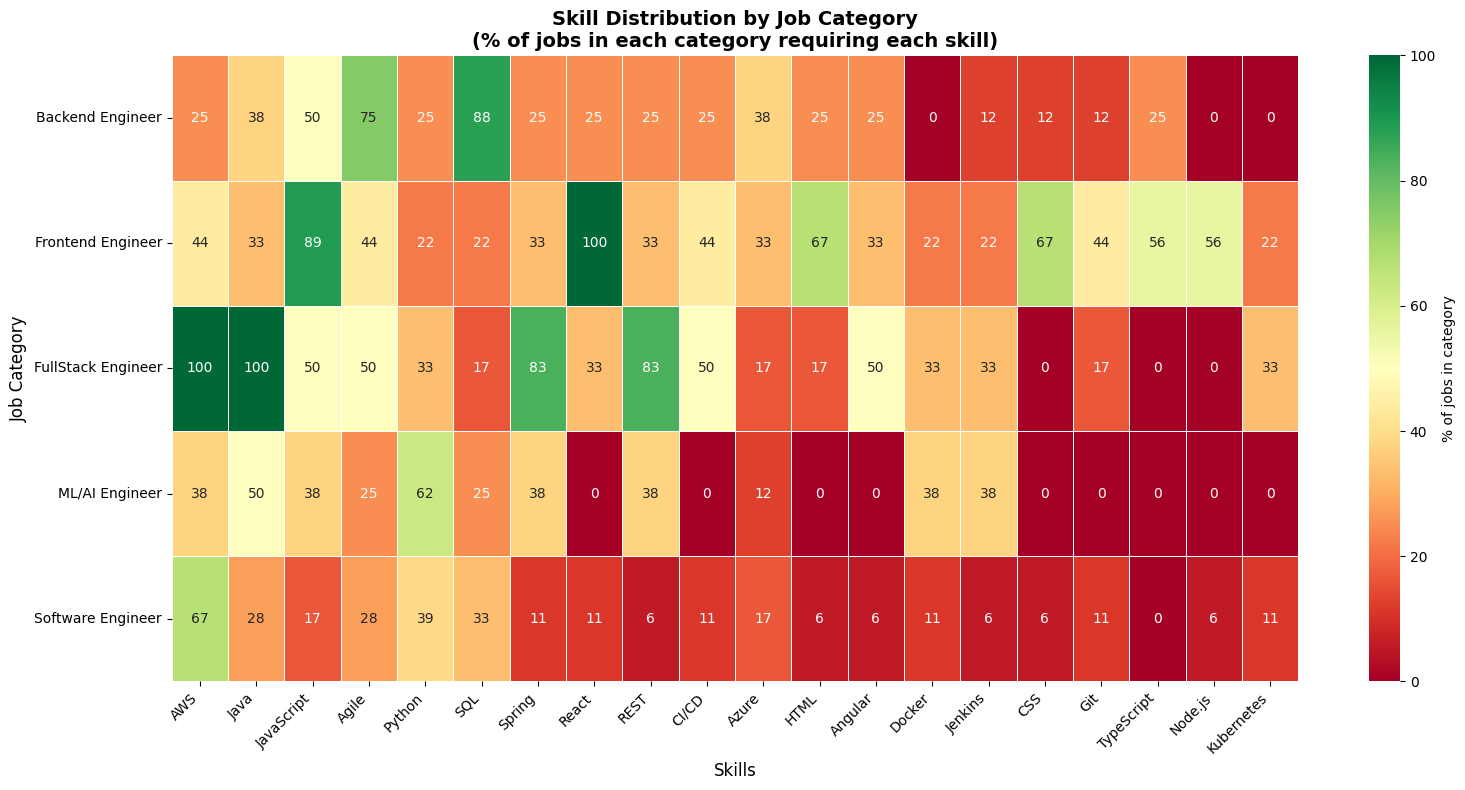

In [15]:
"""
6. HEATMAP: JOB CATEGORY vs TOP SKILLS
Visual representation of skill importance across job categories
"""

# Get top skills overall
all_skills = []
for skills in result_df_categorized['matched_skills']:
    all_skills.extend(skills)
top_overall_skills = [skill for skill, _ in Counter(all_skills).most_common(20)]

# Build matrix: categories x skills
categories = sorted(result_df_categorized['job_category'].unique())
heatmap_data = []

for category in categories:
    category_df = result_df_categorized[result_df_categorized['job_category'] == category]
    job_count = len(category_df)
    
    row = []
    for skill in top_overall_skills:
        # Count how many jobs in this category have this skill
        count = sum(1 for skills in category_df['matched_skills'] if skill in skills)
        percentage = (count / job_count * 100) if job_count > 0 else 0
        row.append(percentage)
    
    heatmap_data.append(row)

# Create heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, 
            xticklabels=top_overall_skills,
            yticklabels=categories,
            cmap='RdYlGn',
            annot=True,
            fmt='.0f',
            cbar_kws={'label': '% of jobs in category'},
            linewidths=0.5)

plt.title('Skill Distribution by Job Category\n(% of jobs in each category requiring each skill)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Skills', fontsize=12)
plt.ylabel('Job Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
"""
7. GENERIC CONFIGURABLE ANALYSIS FUNCTION
No hardcoded parameters - you can adjust everything!
"""

def analyze_skill_patterns(df, 
                           min_support=0.10,
                           min_confidence=0.5,
                           top_n_skills=20,
                           min_cooccurrence=3,
                           max_itemset_length=None):
    """
    Generic function to analyze skill patterns with configurable parameters
    
    Parameters:
    -----------
    df : DataFrame
        Job data with matched_skills column
    min_support : float (0-1)
        Minimum support for frequent itemsets (e.g., 0.10 = appear in 10% of jobs)
    min_confidence : float (0-1)  
        Minimum confidence for association rules
    top_n_skills : int
        Number of top skills to analyze
    min_cooccurrence : int
        Minimum times skills must appear together for network edge
    max_itemset_length : int or None
        Maximum itemset size to return (None = all sizes)
    
    Returns:
    --------
    dict with analysis results
    """
    
    results = {}
    
    # 1. Frequent itemsets
    transactions = df['matched_skills'].tolist()
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    
    if max_itemset_length:
        frequent_itemsets = frequent_itemsets[frequent_itemsets['length'] <= max_itemset_length]
    
    results['frequent_itemsets'] = frequent_itemsets.sort_values('support', ascending=False)
    
    # 2. Association rules
    if len(frequent_itemsets) > 0:
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
        results['rules'] = rules.sort_values('lift', ascending=False)
    else:
        results['rules'] = pd.DataFrame()
    
    # 3. Co-occurrence data
    all_skills = []
    for skills in df['matched_skills']:
        all_skills.extend(skills)
    skill_counts = Counter(all_skills)
    results['skill_frequencies'] = skill_counts
    
    # 4. Network graph
    G = nx.Graph()
    top_skills = set([skill for skill, _ in skill_counts.most_common(top_n_skills)])
    
    for skills in df['matched_skills']:
        filtered_skills = [s for s in skills if s in top_skills]
        for skill1, skill2 in combinations(filtered_skills, 2):
            if G.has_edge(skill1, skill2):
                G[skill1][skill2]['weight'] += 1
            else:
                G.add_edge(skill1, skill2, weight=1)
    
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_cooccurrence]
    G.remove_edges_from(edges_to_remove)
    G.remove_nodes_from(list(nx.isolates(G)))
    
    results['network'] = G
    
    return results

# Example usage with custom parameters
print("="*80)
print("CUSTOM ANALYSIS EXAMPLE")
print("="*80)

# Run analysis with custom parameters
custom_results = analyze_skill_patterns(
    result_df_categorized,
    min_support=0.15,          # Skills must appear in 15% of jobs
    min_confidence=0.6,        # 60% confidence for rules
    top_n_skills=15,           # Focus on top 15 skills
    min_cooccurrence=4,        # Must co-occur at least 4 times
    max_itemset_length=3       # Only look at sets of 3 or fewer skills
)

print(f"\nFound {len(custom_results['frequent_itemsets'])} frequent itemsets")
print(f"Found {len(custom_results['rules'])} association rules")
print(f"Network has {custom_results['network'].number_of_nodes()} nodes and {custom_results['network'].number_of_edges()} edges")

print("\n--- Top 5 Most Frequent Itemsets ---")
for idx, row in custom_results['frequent_itemsets'].head(5).iterrows():
    skills = list(row['itemsets'])
    print(f"{', '.join(skills):50s} | Support: {row['support']*100:.1f}%")

CUSTOM ANALYSIS EXAMPLE

Found 59 frequent itemsets
Found 70 association rules
Network has 15 nodes and 90 edges

--- Top 5 Most Frequent Itemsets ---
AWS                                                | Support: 55.1%
Java                                               | Support: 42.9%
JavaScript                                         | Support: 42.9%
Agile                                              | Support: 40.8%
SQL                                                | Support: 36.7%


In [17]:
"""
8. ITEMSETS BY JOB CATEGORY (GENERIC)
Find frequent skill combinations within each job category
This answers: "What skill sets do Software Engineers typically need?"
"""

def get_itemsets_by_category(df, min_support=0.10, max_length=None, top_n_per_length=10):
    """
    Find frequent itemsets for each job category
    
    Parameters:
    -----------
    df : DataFrame with job_category and matched_skills columns
    min_support : float, minimum support threshold (0-1)
    max_length : int or None, max itemset size
    top_n_per_length : int, how many to show per length
    
    Returns:
    --------
    dict: {category: frequent_itemsets_df}
    """
    
    category_itemsets = {}
    
    for category in df['job_category'].unique():
        category_df = df[df['job_category'] == category]
        
        # Skip if too few jobs
        if len(category_df) < 3:
            continue
        
        # Prepare transactions
        transactions = category_df['matched_skills'].tolist()
        
        if not transactions:
            continue
            
        # One-hot encode
        te = TransactionEncoder()
        te_ary = te.fit(transactions).transform(transactions)
        df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
        
        # Find frequent itemsets
        try:
            itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
            itemsets['length'] = itemsets['itemsets'].apply(lambda x: len(x))
            
            if max_length:
                itemsets = itemsets[itemsets['length'] <= max_length]
            
            itemsets = itemsets.sort_values('support', ascending=False)
            category_itemsets[category] = itemsets
        except:
            # No itemsets found
            pass
    
    return category_itemsets, top_n_per_length


def display_category_itemsets(category_itemsets, df, top_n_per_length):
    """Display itemsets for each category"""
    
    print("="*80)
    print("FREQUENT SKILL ITEMSETS BY JOB CATEGORY")
    print("="*80)
    
    for category in sorted(category_itemsets.keys()):
        itemsets = category_itemsets[category]
        job_count = len(df[df['job_category'] == category])
        
        print(f"\n{'='*80}")
        print(f"{category.upper()} ({job_count} jobs)")
        print(f"{'='*80}")
        
        # Show itemsets grouped by length (generic, no hardcoded labels)
        for length in sorted(itemsets['length'].unique()):
            length_itemsets = itemsets[itemsets['length'] == length].head(top_n_per_length)
            
            if len(length_itemsets) == 0:
                continue
            
            # Generic label
            print(f"\n  {length}-Skill Itemsets:")
            
            for idx, row in length_itemsets.iterrows():
                skills = sorted(list(row['itemsets']))
                support_pct = row['support'] * 100
                count = int(row['support'] * job_count)
                
                skill_str = ', '.join(skills)
                print(f"    • {skill_str:65s} | {support_pct:5.1f}% ({count}/{job_count} jobs)")


# Analyze itemsets by category with configurable parameters
category_itemsets, top_n = get_itemsets_by_category(
    result_df_categorized, 
    min_support=0.15,      # Must appear in at least 15% of jobs in that category
    max_length=4,          # Look at sets up to 4 skills
    top_n_per_length=10    # Show top 10 per length
)

display_category_itemsets(category_itemsets, result_df_categorized, top_n)

FREQUENT SKILL ITEMSETS BY JOB CATEGORY

BACKEND ENGINEER (8 jobs)

  1-Skill Itemsets:
    • SQL                                                               |  87.5% (7/8 jobs)
    • Agile                                                             |  75.0% (6/8 jobs)
    • .NET                                                              |  50.0% (4/8 jobs)
    • JavaScript                                                        |  50.0% (4/8 jobs)
    • Java                                                              |  37.5% (3/8 jobs)
    • Selenium                                                          |  37.5% (3/8 jobs)
    • Azure                                                             |  37.5% (3/8 jobs)
    • TypeScript                                                        |  25.0% (2/8 jobs)
    • TDD                                                               |  25.0% (2/8 jobs)
    • Spring                                                            |  25.0% (2/

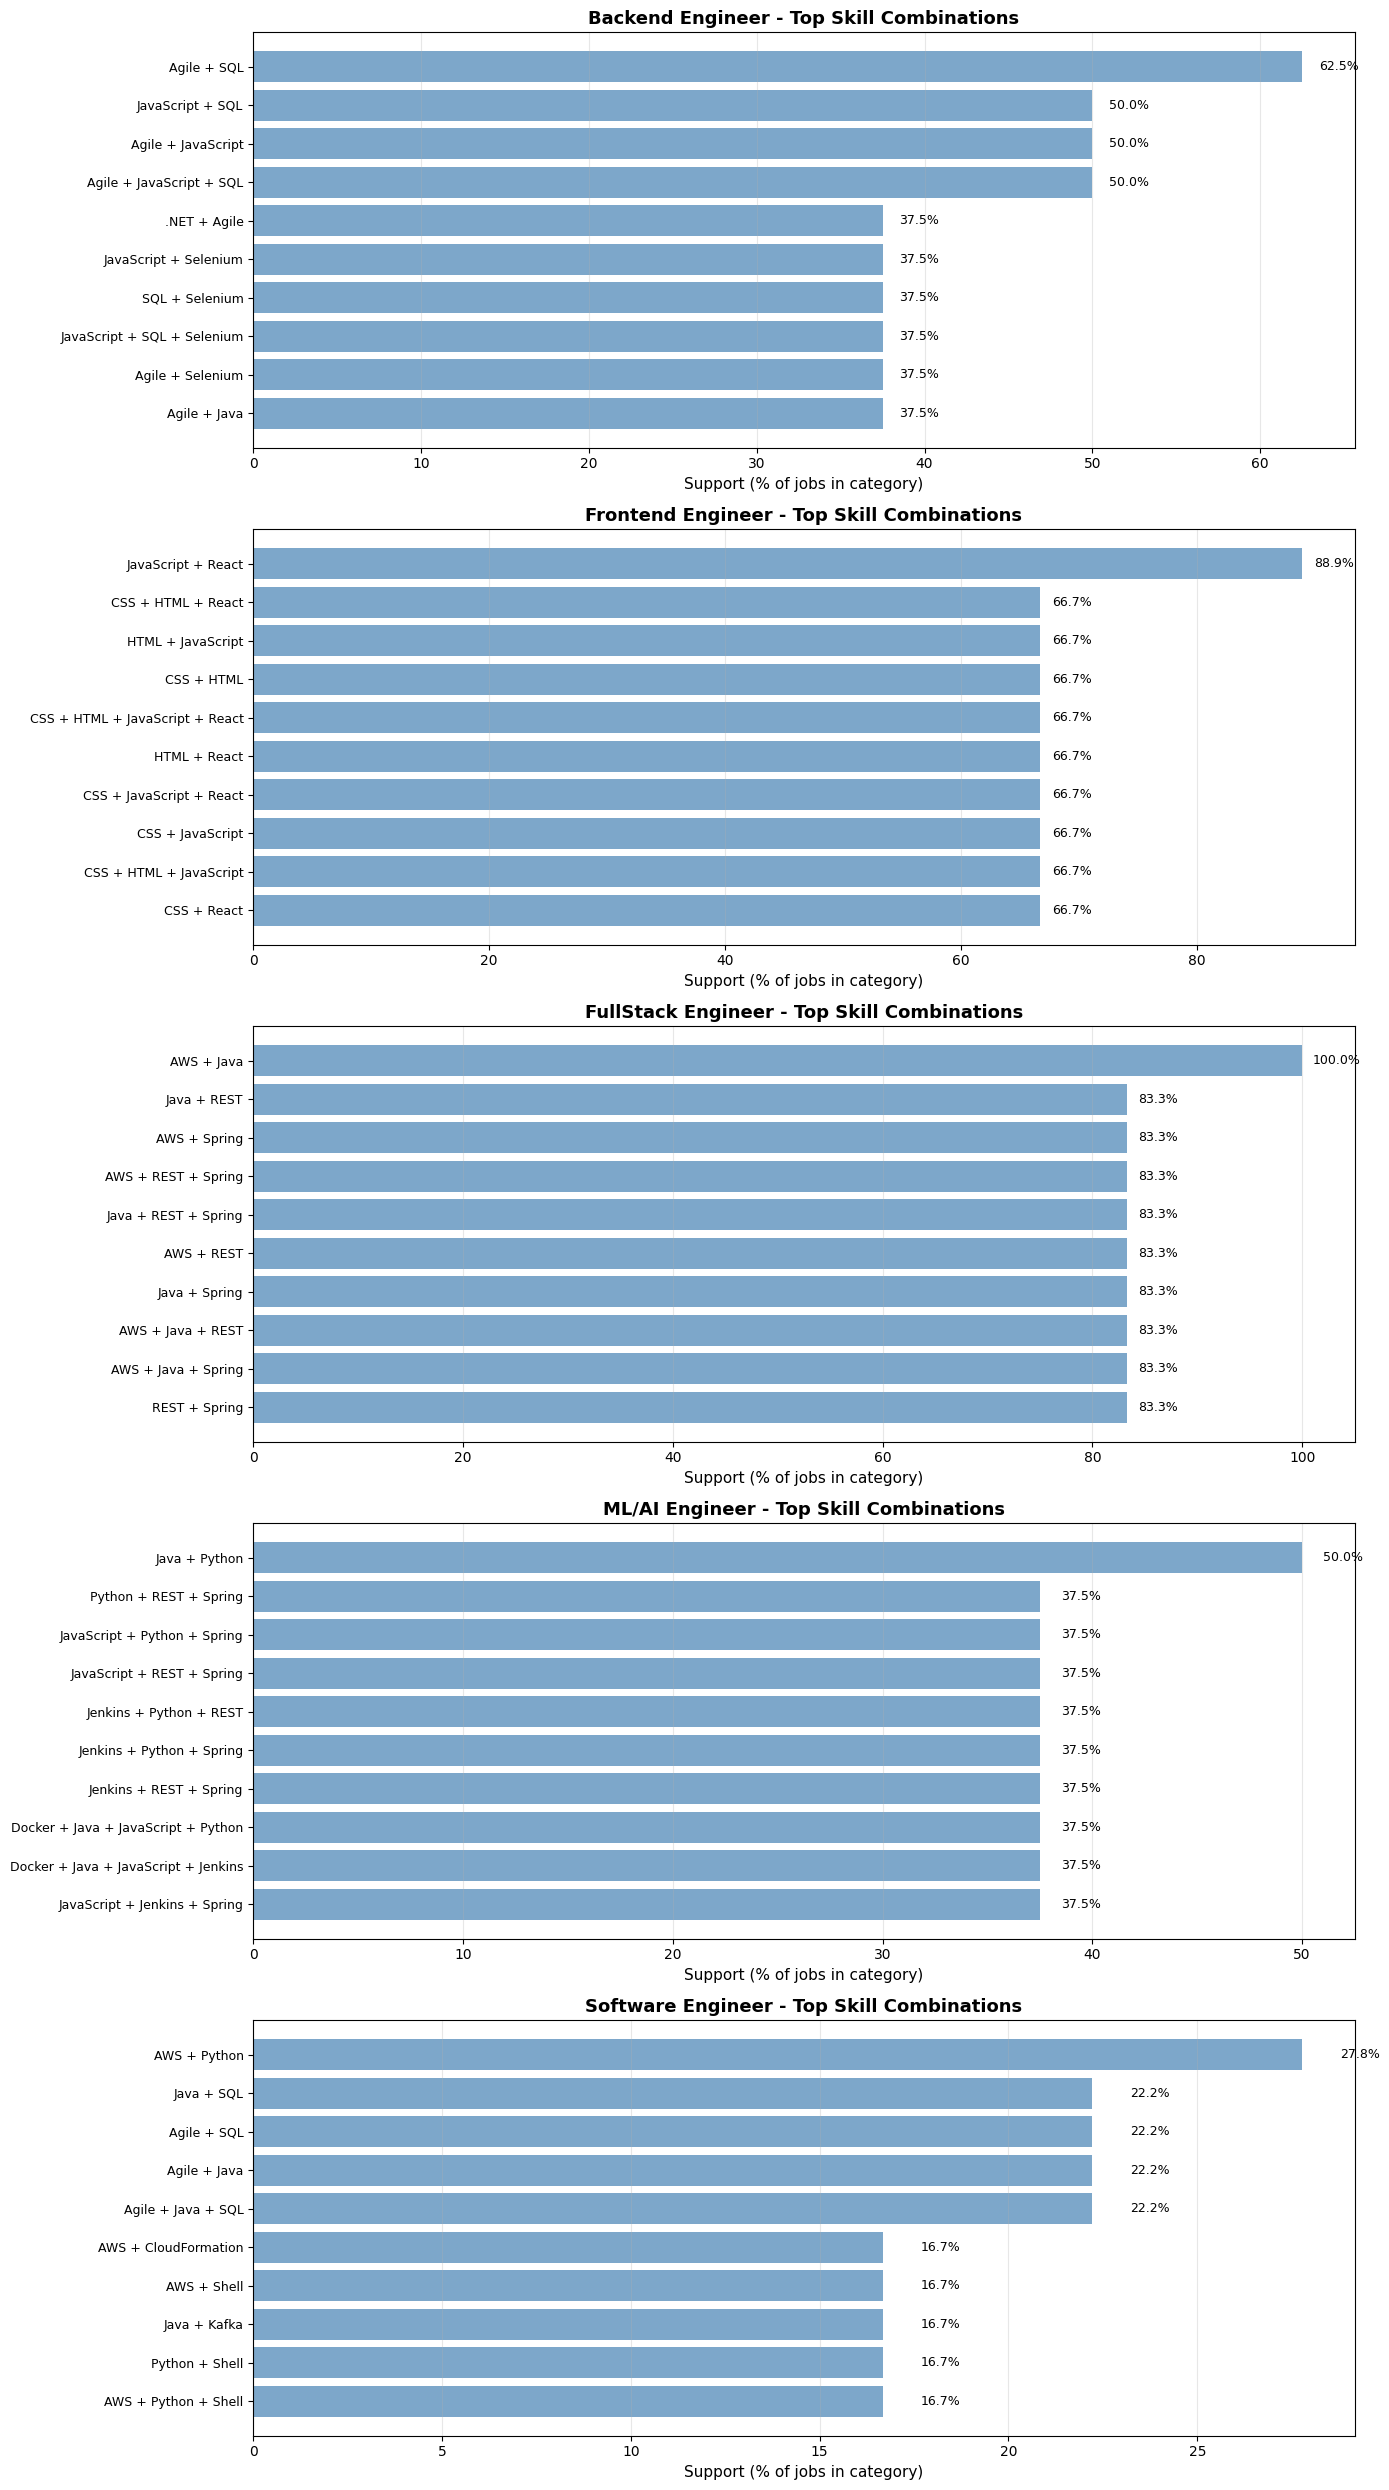

In [18]:
"""
9. VISUALIZATION: TOP SKILL SETS BY JOB CATEGORY
Bar charts showing most common skill combinations per category
"""

fig, axes = plt.subplots(len(category_itemsets), 1, figsize=(14, 5 * len(category_itemsets)))

if len(category_itemsets) == 1:
    axes = [axes]

for idx, (category, itemsets) in enumerate(sorted(category_itemsets.items())):
    ax = axes[idx]
    
    # Get top 10 itemsets (excluding single skills)
    multi_skill_itemsets = itemsets[itemsets['length'] > 1].head(10)
    
    if len(multi_skill_itemsets) == 0:
        # If no multi-skill itemsets, show single skills
        multi_skill_itemsets = itemsets[itemsets['length'] == 1].head(10)
    
    # Prepare data
    labels = []
    supports = []
    
    for _, row in multi_skill_itemsets.iterrows():
        skills = sorted(list(row['itemsets']))
        label = ' + '.join(skills)
        if len(label) > 50:
            label = label[:47] + '...'
        labels.append(label)
        supports.append(row['support'] * 100)
    
    # Create horizontal bar chart
    y_pos = np.arange(len(labels))
    ax.barh(y_pos, supports, color='steelblue', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel('Support (% of jobs in category)', fontsize=11)
    ax.set_title(f'{category} - Top Skill Combinations', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(supports):
        ax.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=9)
    
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [19]:
"""
10. SUMMARY: KEY INSIGHTS
Export itemsets by category to DataFrame for further analysis
"""

def create_category_itemset_summary(category_itemsets, result_df):
    """Create a summary DataFrame of itemsets by category"""
    
    summary_data = []
    
    for category, itemsets in category_itemsets.items():
        job_count = len(result_df[result_df['job_category'] == category])
        
        for _, row in itemsets.iterrows():
            skills = sorted(list(row['itemsets']))
            
            summary_data.append({
                'job_category': category,
                'job_count_in_category': job_count,
                'itemset_size': len(skills),
                'skills': ', '.join(skills),
                'support_pct': round(row['support'] * 100, 1),
                'job_count_with_itemset': int(row['support'] * job_count)
            })
    
    return pd.DataFrame(summary_data)


# Create summary
itemset_summary = create_category_itemset_summary(category_itemsets, result_df_categorized)

print("="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nTotal jobs analyzed: {len(result_df_categorized)}")
print(f"Job categories: {result_df_categorized['job_category'].nunique()}")
print(f"Unique skills found: {len(set([s for skills in result_df_categorized['matched_skills'] for s in skills]))}")

print("\n--- Itemsets by Category ---")
for category in itemset_summary['job_category'].unique():
    cat_itemsets = itemset_summary[itemset_summary['job_category'] == category]
    print(f"{category:25s}: {len(cat_itemsets):3d} itemsets found")

print("\n--- Most Common Skill Combinations Across All Categories ---")
# Get most common multi-skill itemsets
multi_skill = itemset_summary[itemset_summary['itemset_size'] > 1].sort_values('support_pct', ascending=False).head(10)
for idx, row in multi_skill.iterrows():
    print(f"  {row['job_category']:20s} | {row['skills']:50s} | {row['support_pct']:5.1f}%")

# Display sample
print("\n--- Sample of Itemset Summary DataFrame ---")
print(itemset_summary.head(15))

# Optionally save to CSV
# itemset_summary.to_csv('CareerPlanner/Data/job_category_skill_itemsets.csv', index=False)
# print("\nSaved to: CareerPlanner/Data/job_category_skill_itemsets.csv")

SUMMARY STATISTICS

Total jobs analyzed: 49
Job categories: 5
Unique skills found: 62

--- Itemsets by Category ---
Backend Engineer         : 567 itemsets found
Frontend Engineer        : 1299 itemsets found
Software Engineer        :  21 itemsets found
ML/AI Engineer           : 172 itemsets found
FullStack Engineer       : 3677 itemsets found

--- Most Common Skill Combinations Across All Categories ---
  FullStack Engineer   | AWS, Java                                          | 100.0%
  Frontend Engineer    | JavaScript, React                                  |  88.9%
  FullStack Engineer   | Java, Spring                                       |  83.3%
  FullStack Engineer   | AWS, Java, Spring                                  |  83.3%
  FullStack Engineer   | AWS, Java, REST, Spring                            |  83.3%
  FullStack Engineer   | AWS, Java, REST                                    |  83.3%
  FullStack Engineer   | REST, Spring                                       |  8

In [20]:
"""
11. JOB CATEGORY → SKILL ASSOCIATIONS WITH LIFT
Rank skills by interestingness (lift) rather than just frequency
Lift > 1: Skill is more common in this category than expected
"""

def calculate_job_skill_metrics(df):
    """
    Calculate lift, confidence, and leverage for job_category → skill associations
    
    Returns:
    --------
    DataFrame with metrics for each (category, skill) pair
    """
    total_jobs = len(df)
    
    # Calculate P(Category) for each category
    category_counts = df['job_category'].value_counts()
    
    # Calculate P(Skill) for each skill
    skill_counts = Counter()
    for skills in df['matched_skills']:
        skill_counts.update(skills)
    
    # Calculate P(Category AND Skill) - co-occurrence
    associations = []
    
    for category in df['job_category'].unique():
        category_df = df[df['job_category'] == category]
        category_count = len(category_df)
        
        # P(Category)
        p_category = category_count / total_jobs
        
        # Count skills in this category
        category_skill_counts = Counter()
        for skills in category_df['matched_skills']:
            category_skill_counts.update(skills)
        
        for skill, count in category_skill_counts.items():
            # P(Skill)
            p_skill = skill_counts[skill] / total_jobs
            
            # P(Category AND Skill)
            p_category_and_skill = count / total_jobs
            
            # Confidence: P(Skill | Category) = P(Category AND Skill) / P(Category)
            confidence = count / category_count
            
            # Lift: P(Skill | Category) / P(Skill)
            lift = confidence / p_skill if p_skill > 0 else 0
            
            # Leverage: P(Category AND Skill) - P(Category) * P(Skill)
            leverage = p_category_and_skill - (p_category * p_skill)
            
            associations.append({
                'job_category': category,
                'skill': skill,
                'count_in_category': count,
                'category_total': category_count,
                'support': p_category_and_skill,
                'confidence': confidence,
                'lift': lift,
                'leverage': leverage,
                'skill_total_frequency': skill_counts[skill]
            })
    
    return pd.DataFrame(associations)


# Calculate metrics
job_skill_metrics = calculate_job_skill_metrics(result_df_categorized)

print("="*80)
print("JOB CATEGORY → SKILL ASSOCIATIONS")
print("="*80)
print("\nMetrics Explained:")
print("  Support: How often category+skill appear together")
print("  Confidence: P(skill | category) - % of category jobs requiring skill")
print("  Lift: How much more likely skill appears in category vs overall")
print("  Leverage: Significance of the association\n")

# Show top skills by different metrics for each category
for category in sorted(job_skill_metrics['job_category'].unique()):
    cat_data = job_skill_metrics[job_skill_metrics['job_category'] == category]
    
    print(f"\n{'='*80}")
    print(f"{category.upper()}")
    print(f"{'='*80}")
    
    print(f"\nTop 10 by LIFT (most distinctive/interesting skills):")
    top_lift = cat_data.nlargest(10, 'lift')
    for idx, row in top_lift.iterrows():
        print(f"  {row['skill']:30s} | Lift: {row['lift']:5.2f} | "
              f"Conf: {row['confidence']*100:5.1f}% | "
              f"Count: {row['count_in_category']:2.0f}/{row['category_total']:2.0f}")
    
    print(f"\nTop 10 by CONFIDENCE (most common skills):")
    top_conf = cat_data.nlargest(10, 'confidence')
    for idx, row in top_conf.iterrows():
        print(f"  {row['skill']:30s} | Conf: {row['confidence']*100:5.1f}% | "
              f"Lift: {row['lift']:5.2f} | "
              f"Count: {row['count_in_category']:2.0f}/{row['category_total']:2.0f}")

JOB CATEGORY → SKILL ASSOCIATIONS

Metrics Explained:
  Support: How often category+skill appear together
  Confidence: P(skill | category) - % of category jobs requiring skill
  Lift: How much more likely skill appears in category vs overall
  Leverage: Significance of the association


BACKEND ENGINEER

Top 10 by LIFT (most distinctive/interesting skills):
  Power BI                       | Lift:  6.13 | Conf:  12.5% | Count:  1/ 8
  FastAPI                        | Lift:  6.13 | Conf:  12.5% | Count:  1/ 8
  C#                             | Lift:  6.13 | Conf:  25.0% | Count:  2/ 8
  GitHub Actions                 | Lift:  6.13 | Conf:  12.5% | Count:  1/ 8
  jQuery                         | Lift:  6.13 | Conf:  12.5% | Count:  1/ 8
  .NET                           | Lift:  4.90 | Conf:  50.0% | Count:  4/ 8
  Selenium                       | Lift:  4.59 | Conf:  37.5% | Count:  3/ 8
  Ruby                           | Lift:  4.08 | Conf:  25.0% | Count:  2/ 8
  Django               

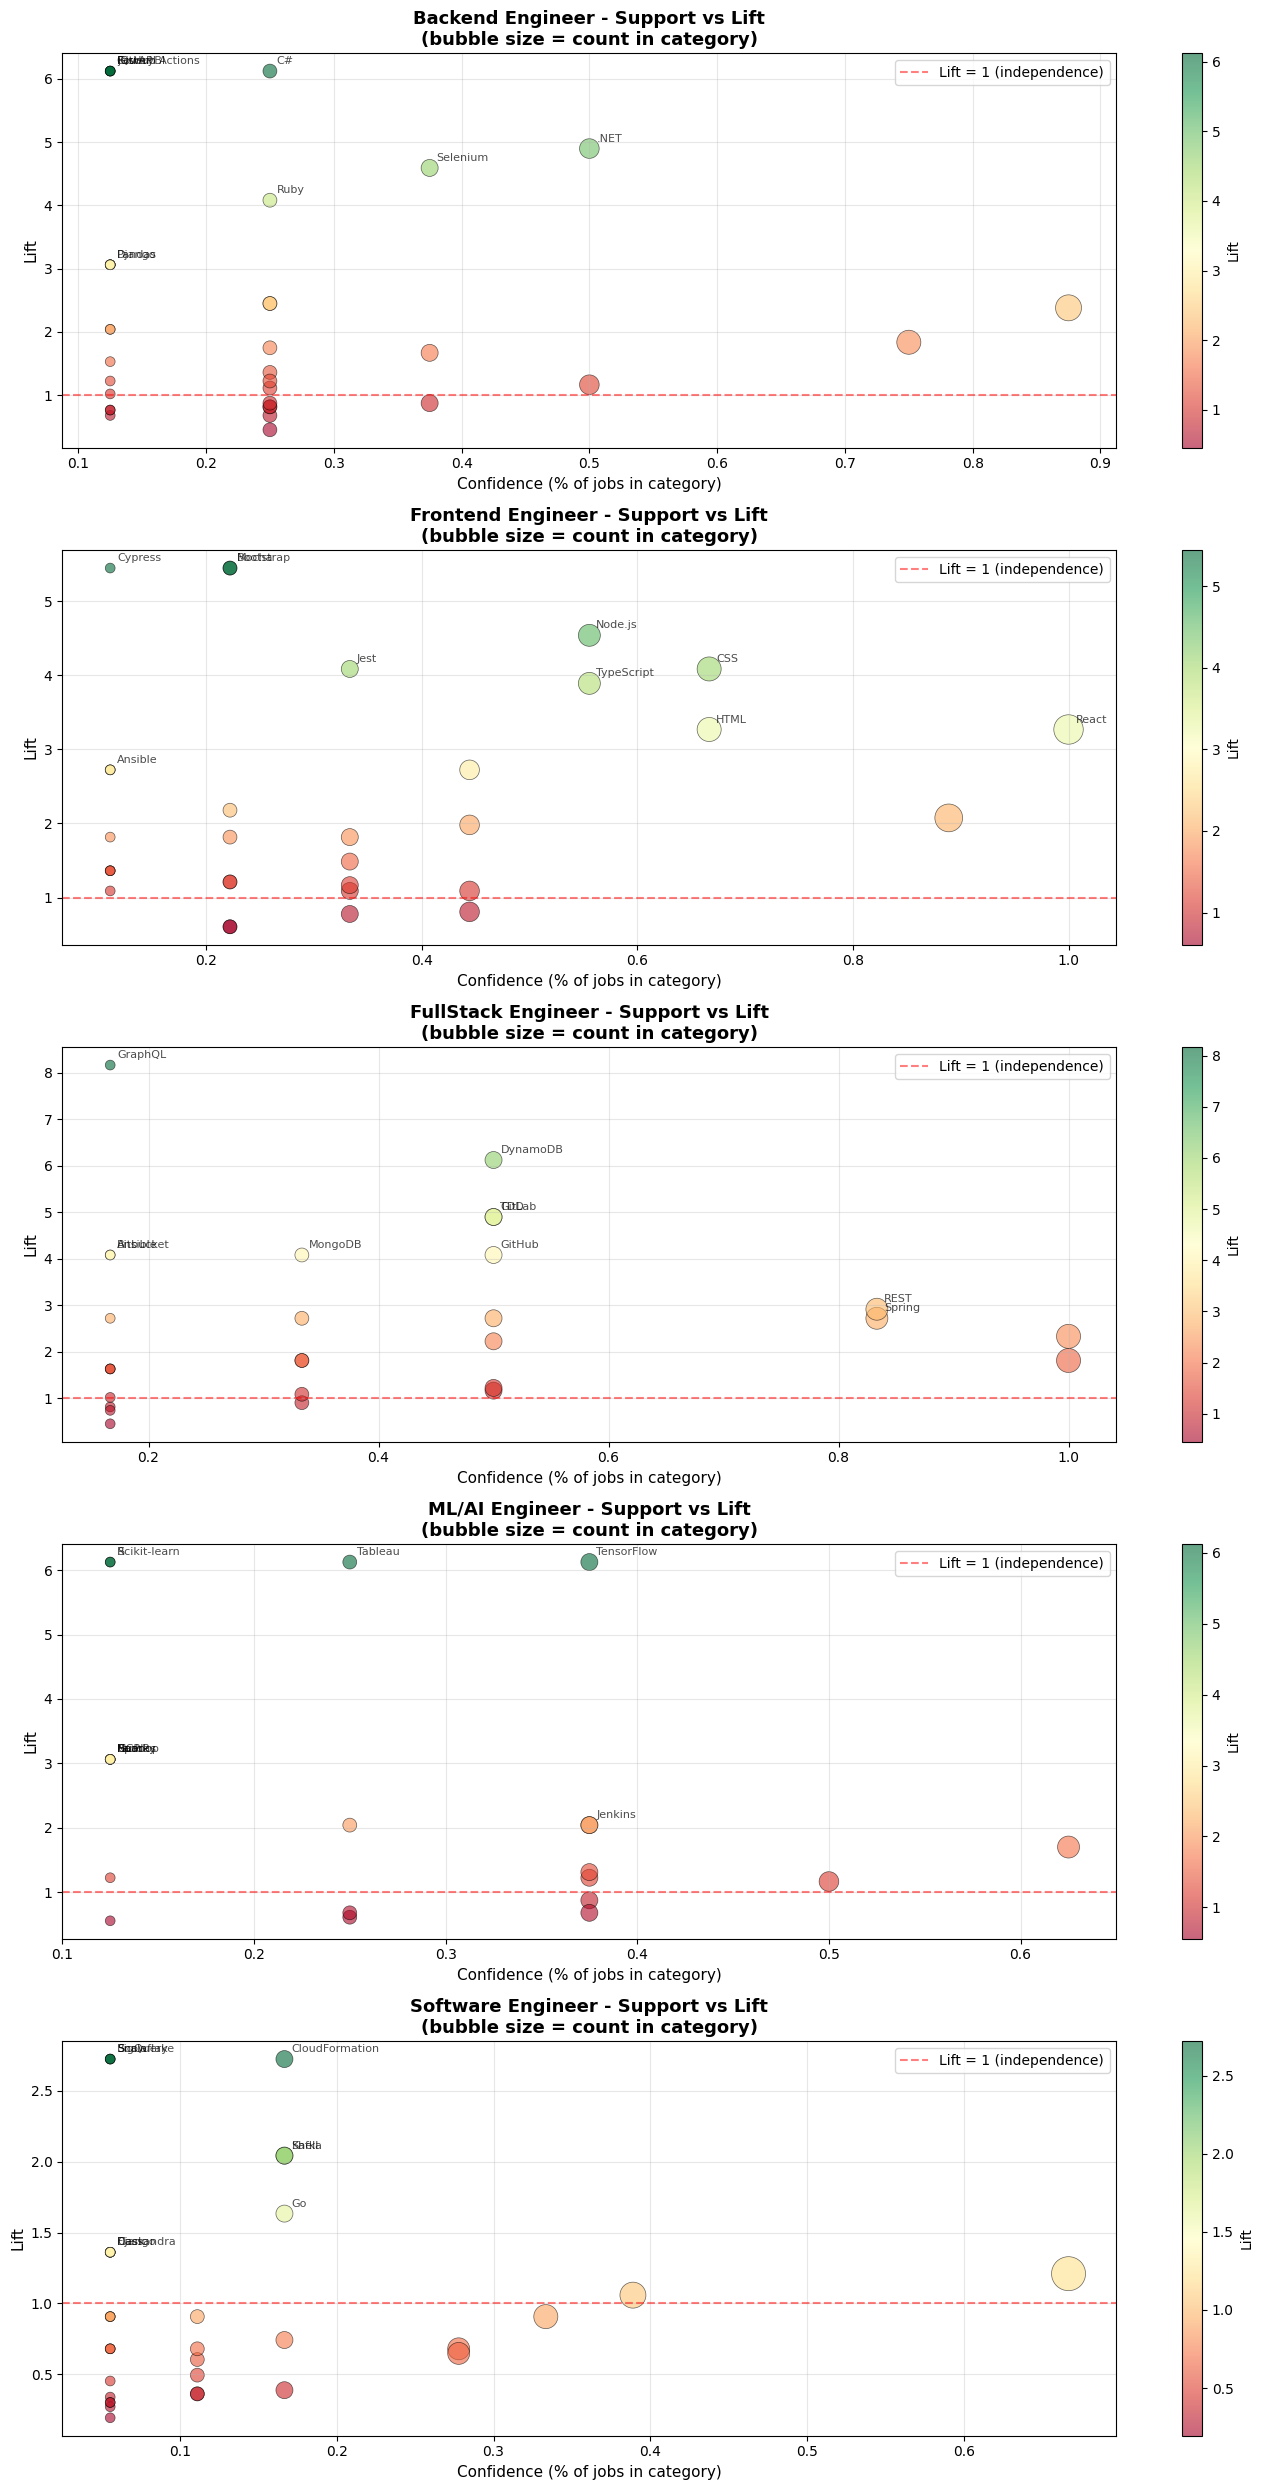


INTERPRETATION GUIDE

Quadrants:
  • High Confidence, High Lift (top-right): Very common AND distinctive skills
  • Low Confidence, High Lift (top-left): Rare but highly characteristic skills
  • High Confidence, Low Lift (bottom-right): Common but not distinctive
  • Low Confidence, Low Lift (bottom-left): Rare and not characteristic
  
Most interesting skills are typically in top-left or top-right quadrants!



In [21]:
"""
12. SUPPORT vs LIFT VISUALIZATION
Identify interesting vs common patterns for each job category
"""

# Create support vs lift scatter plots for each category
categories = sorted(job_skill_metrics['job_category'].unique())
n_categories = len(categories)

fig, axes = plt.subplots(n_categories, 1, figsize=(14, 5 * n_categories))

if n_categories == 1:
    axes = [axes]

for idx, category in enumerate(categories):
    ax = axes[idx]
    cat_data = job_skill_metrics[job_skill_metrics['job_category'] == category]
    
    # Create scatter plot
    scatter = ax.scatter(cat_data['confidence'], 
                        cat_data['lift'],
                        s=cat_data['count_in_category']*50,
                        c=cat_data['lift'],
                        cmap='RdYlGn',
                        alpha=0.6,
                        edgecolors='black',
                        linewidth=0.5)
    
    # Add reference line at lift=1
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Lift = 1 (independence)')
    
    # Annotate top lift points
    top_lift = cat_data.nlargest(10, 'lift')
    for _, row in top_lift.iterrows():
        ax.annotate(row['skill'], 
                   (row['confidence'], row['lift']),
                   fontsize=8,
                   alpha=0.7,
                   xytext=(5, 5),
                   textcoords='offset points')
    
    ax.set_xlabel('Confidence (% of jobs in category)', fontsize=11)
    ax.set_ylabel('Lift', fontsize=11)
    ax.set_title(f'{category} - Support vs Lift\n(bubble size = count in category)', 
                fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax, label='Lift')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETATION GUIDE")
print("="*80)
print("""
Quadrants:
  • High Confidence, High Lift (top-right): Very common AND distinctive skills
  • Low Confidence, High Lift (top-left): Rare but highly characteristic skills
  • High Confidence, Low Lift (bottom-right): Common but not distinctive
  • Low Confidence, Low Lift (bottom-left): Rare and not characteristic
  
Most interesting skills are typically in top-left or top-right quadrants!
""")

MOST DISTINCTIVE SKILLS BY JOB CATEGORY

(Filtered: confidence >= 20% to focus on common skills with high lift)


Backend Engineer:
------------------------------------------------------------
  • C#                             | Lift:  6.13 | In  25.0% of jobs
  • .NET                           | Lift:  4.90 | In  50.0% of jobs
  • Selenium                       | Lift:  4.59 | In  37.5% of jobs
  • Ruby                           | Lift:  4.08 | In  25.0% of jobs
  • TDD                            | Lift:  2.45 | In  25.0% of jobs

Frontend Engineer:
------------------------------------------------------------
  • Bootstrap                      | Lift:  5.44 | In  22.2% of jobs
  • Mocha                          | Lift:  5.44 | In  22.2% of jobs
  • Node.js                        | Lift:  4.54 | In  55.6% of jobs
  • CSS                            | Lift:  4.08 | In  66.7% of jobs
  • Jest                           | Lift:  4.08 | In  33.3% of jobs

FullStack Engineer:
---------------

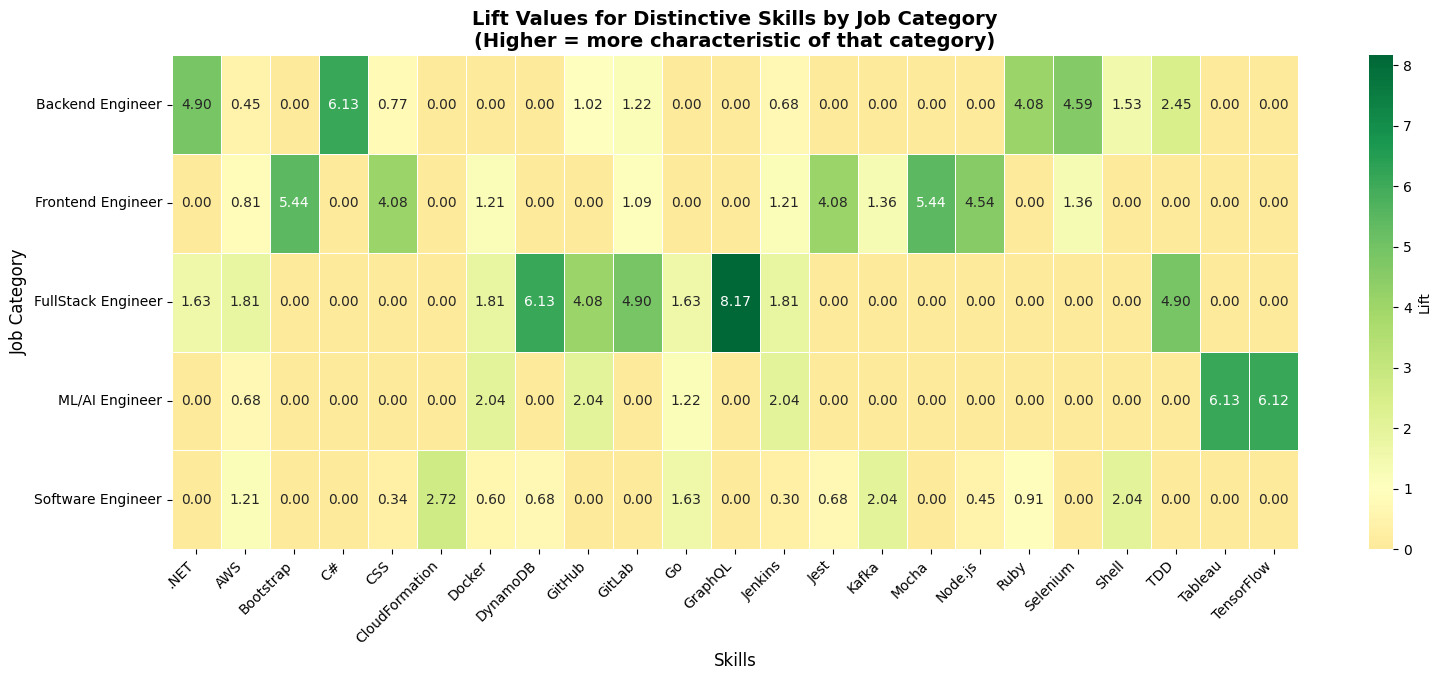

In [22]:
"""
13. MOST DISTINCTIVE SKILLS BY CATEGORY (HIGH LIFT)
Summary table comparing what makes each job category unique
"""

# Create summary of most distinctive skills per category
distinctive_skills = {}

for category in sorted(job_skill_metrics['job_category'].unique()):
    cat_data = job_skill_metrics[job_skill_metrics['job_category'] == category]
    
    # Get top 5 by lift (minimum confidence 20% to avoid rare skills)
    filtered = cat_data[cat_data['confidence'] >= 0.20]
    top_distinctive = filtered.nlargest(5, 'lift')
    
    distinctive_skills[category] = top_distinctive[['skill', 'lift', 'confidence']].values.tolist()

# Display as table
print("="*80)
print("MOST DISTINCTIVE SKILLS BY JOB CATEGORY")
print("="*80)
print("\n(Filtered: confidence >= 20% to focus on common skills with high lift)\n")

for category, skills in distinctive_skills.items():
    print(f"\n{category}:")
    print("-" * 60)
    for skill, lift, conf in skills:
        print(f"  • {skill:30s} | Lift: {lift:5.2f} | In {conf*100:5.1f}% of jobs")

# Create visual comparison
print("\n" + "="*80)
print("HEATMAP: LIFT VALUES FOR TOP SKILLS BY CATEGORY")
print("="*80)

# Get top N distinctive skills per category
top_n_per_cat = 5
all_distinctive = set()
category_skill_lifts = {}

for category in sorted(job_skill_metrics['job_category'].unique()):
    cat_data = job_skill_metrics[job_skill_metrics['job_category'] == category]
    filtered = cat_data[cat_data['confidence'] >= 0.15]
    top_skills = filtered.nlargest(top_n_per_cat, 'lift')['skill'].tolist()
    all_distinctive.update(top_skills)
    
    # Store lift values
    category_skill_lifts[category] = cat_data.set_index('skill')['lift'].to_dict()

# Build heatmap data
distinctive_list = sorted(all_distinctive)
heatmap_data = []

for category in sorted(job_skill_metrics['job_category'].unique()):
    row = []
    for skill in distinctive_list:
        lift = category_skill_lifts[category].get(skill, 0)
        row.append(lift)
    heatmap_data.append(row)

# Plot heatmap
plt.figure(figsize=(16, max(6, len(distinctive_list) * 0.3)))
sns.heatmap(heatmap_data,
            xticklabels=distinctive_list,
            yticklabels=sorted(job_skill_metrics['job_category'].unique()),
            cmap='RdYlGn',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Lift'},
            linewidths=0.5,
            center=1.0)

plt.title('Lift Values for Distinctive Skills by Job Category\n(Higher = more characteristic of that category)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Skills', fontsize=12)
plt.ylabel('Job Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
"""
23. BUILD KNOWLEDGE GRAPH - PART 5: SKILLSET NODES (FIXED)
Add Skillset nodes for high-lift skill combinations
"""

print("="*80)
print("ADDING SKILLSET NODES & RELATIONSHIPS")
print("="*80)

# Step 1: Add Skillset nodes from high-lift job→skillset rules
min_lift = 2.0  # Only create nodes for high-lift combinations
min_skill_count = 2  # At least 2 skills

skillset_count = 0
high_lift_skillsets = job_skillset_rules[
    (job_skillset_rules['lift'] >= min_lift) & 
    (job_skillset_rules['skill_count'] >= min_skill_count)
]

print(f"\n1. Creating Skillset nodes (lift ≥ {min_lift}, size ≥ {min_skill_count})...")
print(f"   Found {len(high_lift_skillsets)} qualifying skillsets")

# Use set to avoid duplicate skillsets
added_skillsets = set()

for _, row in high_lift_skillsets.iterrows():
    # Create unique ID for skillset (sorted skills joined)
    skills_list = sorted(row['skills'].split(', '))
    skillset_id = ' + '.join(skills_list)
    
    if skillset_id not in added_skillsets:
        KG.add_node(
            skillset_id,
            node_type='Skillset',
            skills=skills_list,
            size=len(skills_list),
            max_lift=row['lift'],  # Store highest lift seen for this combo
            categories=[]  # Will track which categories use this
        )
        added_skillsets.add(skillset_id)
        skillset_count += 1

print(f"   ✓ Added {skillset_count} Skillset nodes")

# Step 2: Add PART_OF relationships (Skill → Skillset)
print("\n2. Adding PART_OF relationships (Skill → Skillset)...")
part_of_count = 0

for skillset_id in added_skillsets:
    skills_list = KG.nodes[skillset_id]['skills']
    for skill in skills_list:
        if skill in KG.nodes:  # Make sure skill node exists
            KG.add_edge(
                skill,
                skillset_id,
                relationship='PART_OF'
            )
            part_of_count += 1
        else:
            print(f"   ⚠️  Warning: Skill '{skill}' not found in graph")

print(f"   ✓ Added {part_of_count} PART_OF edges")

# Step 3: Add CHARACTERISTIC_SKILLSET relationships (JobCategory → Skillset)
print("\n3. Adding CHARACTERISTIC_SKILLSET relationships (JobCategory → Skillset)...")
char_skillset_count = 0

for _, row in high_lift_skillsets.iterrows():
    skills_list = sorted(row['skills'].split(', '))
    skillset_id = ' + '.join(skills_list)
    
    # Add edge from job category to skillset
    if row['job_category'] in KG.nodes and skillset_id in KG.nodes:
        KG.add_edge(
            row['job_category'],
            skillset_id,
            relationship='CHARACTERISTIC_SKILLSET',
            lift=round(row['lift'], 2),
            confidence=round(row['confidence'], 3),
            support=round(row['support'], 3)
        )
        
        # Track which categories use this skillset
        if row['job_category'] not in KG.nodes[skillset_id]['categories']:
            KG.nodes[skillset_id]['categories'].append(row['job_category'])
        
        char_skillset_count += 1

print(f"   ✓ Added {char_skillset_count} CHARACTERISTIC_SKILLSET edges")

# Show examples
print("\n📊 Top 5 Skillsets by lift:")
top_skillsets = high_lift_skillsets.nlargest(5, 'lift')
for _, row in top_skillsets.iterrows():
    print(f"\n  • {row['skills']}")
    print(f"    Size: {row['skill_count']} skills")
    print(f"    Lift: {row['lift']:.2f}")
    print(f"    Category: {row['job_category']}")
    print(f"    Confidence: {row['confidence']*100:.1f}%")

print(f"\n✓ Total nodes in graph: {KG.number_of_nodes()}")
print(f"✓ Total edges in graph: {KG.number_of_edges()}")

# Verify Skillset nodes were added
skillset_nodes = [n for n, d in KG.nodes(data=True) if d.get('node_type') == 'Skillset']
print(f"✓ Skillset nodes in graph: {len(skillset_nodes)}")

ADDING SKILLSET NODES & RELATIONSHIPS


NameError: name 'job_skillset_rules' is not defined

In [24]:
"""
15. VISUALIZE SKILL COMBINATION RULES
Support vs Lift scatter plots for association rules by category
"""

# Create visualizations for each category's rules
fig, axes = plt.subplots(len(category_rules), 1, figsize=(14, 6 * len(category_rules)))

if len(category_rules) == 1:
    axes = [axes]

for idx, (category, rules) in enumerate(sorted(category_rules.items())):
    ax = axes[idx]
    
    # Create scatter plot
    scatter = ax.scatter(rules['support'], 
                        rules['lift'],
                        s=rules['confidence']*300,
                        c=rules['lift'],
                        cmap='RdYlGn',
                        alpha=0.6,
                        edgecolors='black',
                        linewidth=0.5)
    
    # Add reference line at lift=1
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Lift = 1 (independence)')
    
    # Annotate top lift rules
    top_rules = rules.nlargest(8, 'lift')
    for _, rule in top_rules.iterrows():
        antecedents = ', '.join(sorted(list(rule['antecedents'])))
        consequents = ', '.join(sorted(list(rule['consequents'])))
        label = f"{antecedents} → {consequents}"
        if len(label) > 30:
            label = label[:27] + '...'
        
        ax.annotate(label, 
                   (rule['support'], rule['lift']),
                   fontsize=7,
                   alpha=0.7,
                   xytext=(5, 5),
                   textcoords='offset points')
    
    ax.set_xlabel('Support (frequency in category)', fontsize=11)
    ax.set_ylabel('Lift', fontsize=11)
    ax.set_title(f'{category} - Association Rules: Support vs Lift\n(bubble size = confidence)', 
                fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax, label='Lift')

plt.tight_layout()
plt.show()

# Create summary DataFrame for easy filtering
print("\n" + "="*80)
print("CREATING EXPORTABLE SUMMARY")
print("="*80)

all_rules_data = []

for category, rules in category_rules.items():
    for _, rule in rules.iterrows():
        antecedents = ', '.join(sorted(list(rule['antecedents'])))
        consequents = ', '.join(sorted(list(rule['consequents'])))
        
        all_rules_data.append({
            'job_category': category,
            'IF': antecedents,
            'THEN': consequents,
            'support': round(rule['support'], 3),
            'confidence': round(rule['confidence'], 3),
            'lift': round(rule['lift'], 2),
            'leverage': round(rule['leverage'], 3),
            'conviction': round(rule['conviction'], 2) if 'conviction' in rule else None
        })

rules_summary = pd.DataFrame(all_rules_data)
rules_summary = rules_summary.sort_values(['job_category', 'lift'], ascending=[True, False])

print(f"\nCreated summary with {len(rules_summary)} rules across {len(category_rules)} categories")
print("\nSample - Top rules by lift:")
print(rules_summary.head(20).to_string(index=False))

print("\n\nTo explore Backend Engineer rules specifically:")
print("  backend_rules = rules_summary[rules_summary['job_category'] == 'Backend Engineer']")
print("  backend_rules.sort_values('lift', ascending=False)")

# Optionally save
# rules_summary.to_csv('CareerPlanner/Data/job_category_skill_rules.csv', index=False)
# print("\n✓ Saved to: CareerPlanner/Data/job_category_skill_rules.csv")

NameError: name 'category_rules' is not defined

In [25]:
"""
16. JOB CATEGORY → SKILL COMBINATIONS (CROSS-CATEGORY COMPARISON)
Generate rules like: IF FullStack Engineer THEN {Python, SQL, React}
Rank by lift to find most distinctive job-skillset combinations across all categories
"""

def generate_job_to_skillset_rules(df, min_support=0.05, min_confidence=0.3):
    """
    Generate association rules: Job Category → Skill Combinations
    
    This treats job_category as a feature in the transaction, allowing us to create
    rules like "IF Backend Engineer THEN {Docker, Kubernetes}"
    
    Parameters:
    -----------
    df : DataFrame with job_category and matched_skills columns
    min_support : float, minimum support threshold
    min_confidence : float, minimum confidence threshold
    
    Returns:
    --------
    DataFrame with rules ranked by lift
    """
    
    # Create transactions that include job_category as an item
    transactions = []
    for _, row in df.iterrows():
        # Prefix job category to distinguish from skills
        transaction = [f"JOB:{row['job_category']}"] + row['matched_skills']
        transactions.append(transaction)
    
    # One-hot encode
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    
    # Find frequent itemsets
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    
    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    
    # Filter to only rules where antecedent is a job category
    job_rules = []
    
    for _, rule in rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        
        # Check if antecedent contains exactly one job category and no skills
        job_categories = [item for item in antecedents if item.startswith('JOB:')]
        skills_in_antecedent = [item for item in antecedents if not item.startswith('JOB:')]
        
        # We want rules where antecedent is ONLY a job category
        if len(job_categories) == 1 and len(skills_in_antecedent) == 0:
            # Consequent should only contain skills
            skills_in_consequent = [item for item in consequents if not item.startswith('JOB:')]
            
            if len(skills_in_consequent) > 0:
                job_category = job_categories[0].replace('JOB:', '')
                
                job_rules.append({
                    'job_category': job_category,
                    'skills': ', '.join(sorted(skills_in_consequent)),
                    'skill_count': len(skills_in_consequent),
                    'support': rule['support'],
                    'confidence': rule['confidence'],
                    'lift': rule['lift'],
                    'leverage': rule['leverage'],
                    'conviction': rule['conviction']
                })
    
    return pd.DataFrame(job_rules).sort_values('lift', ascending=False)


# Generate job → skillset rules
print("="*80)
print("GENERATING JOB CATEGORY → SKILL COMBINATION RULES")
print("="*80)
print("\nThis shows which skill combinations are most distinctive for each job type")
print("Higher lift = more characteristic of that job category\n")

job_skillset_rules = generate_job_to_skillset_rules(
    result_df_categorized,
    min_support=0.08,      # Must appear in 8% of all jobs
    min_confidence=0.30    # 30% of that job category has this skillset
)

print(f"Generated {len(job_skillset_rules)} rules\n")

# Show top rules by lift
print("="*80)
print("TOP 30 MOST DISTINCTIVE JOB → SKILLSET COMBINATIONS (BY LIFT)")
print("="*80)
print()

for idx, row in job_skillset_rules.head(30).iterrows():
    print(f"{row['job_category']:25s} → {row['skills']}")
    print(f"  Lift: {row['lift']:5.2f} | "
          f"Confidence: {row['confidence']*100:5.1f}% | "
          f"Support: {row['support']*100:5.1f}% | "
          f"Skills: {row['skill_count']}")
    print()

# Group by category to see best skillsets per job type
print("\n" + "="*80)
print("MOST DISTINCTIVE SKILLSETS BY JOB CATEGORY")
print("="*80)

for category in sorted(job_skillset_rules['job_category'].unique()):
    cat_rules = job_skillset_rules[job_skillset_rules['job_category'] == category]
    print(f"\n{category}:")
    print("-" * 80)
    
    # Show top 5 by lift
    for idx, row in cat_rules.head(5).iterrows():
        print(f"  • {row['skills']:60s}")
        print(f"    Lift: {row['lift']:5.2f} | Conf: {row['confidence']*100:5.1f}%")
    
print("\n\nDataFrame available as: job_skillset_rules")
print("Filter by category: job_skillset_rules[job_skillset_rules['job_category'] == 'Backend Engineer']")

GENERATING JOB CATEGORY → SKILL COMBINATION RULES

This shows which skill combinations are most distinctive for each job type
Higher lift = more characteristic of that job category

Generated 132 rules

TOP 30 MOST DISTINCTIVE JOB → SKILLSET COMBINATIONS (BY LIFT)

FullStack Engineer        → AWS, REST, Spring
  Lift:  5.83 | Confidence:  83.3% | Support:  10.2% | Skills: 3

FullStack Engineer        → AWS, Java, REST
  Lift:  5.83 | Confidence:  83.3% | Support:  10.2% | Skills: 3

FullStack Engineer        → AWS, Java, REST, Spring
  Lift:  5.83 | Confidence:  83.3% | Support:  10.2% | Skills: 4

Frontend Engineer         → HTML, React
  Lift:  5.44 | Confidence:  66.7% | Support:  12.2% | Skills: 2

Frontend Engineer         → CSS, React
  Lift:  5.44 | Confidence:  66.7% | Support:  12.2% | Skills: 2

Frontend Engineer         → CSS, JavaScript, React
  Lift:  5.44 | Confidence:  66.7% | Support:  12.2% | Skills: 3

Frontend Engineer         → CSS, HTML, JavaScript, React
  Lift:  

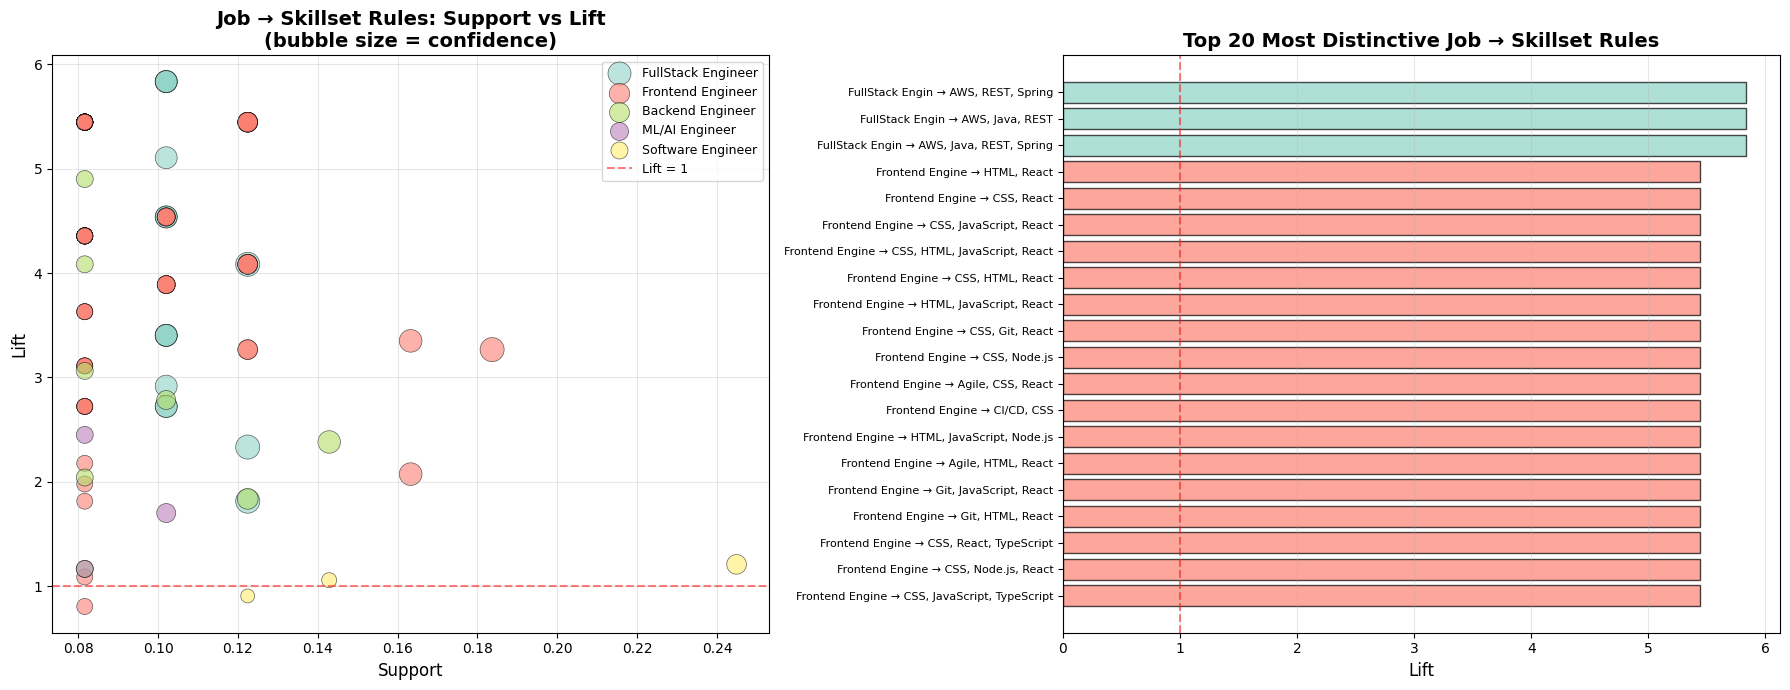


LIFT COMPARISON BY SKILL COMBINATION SIZE


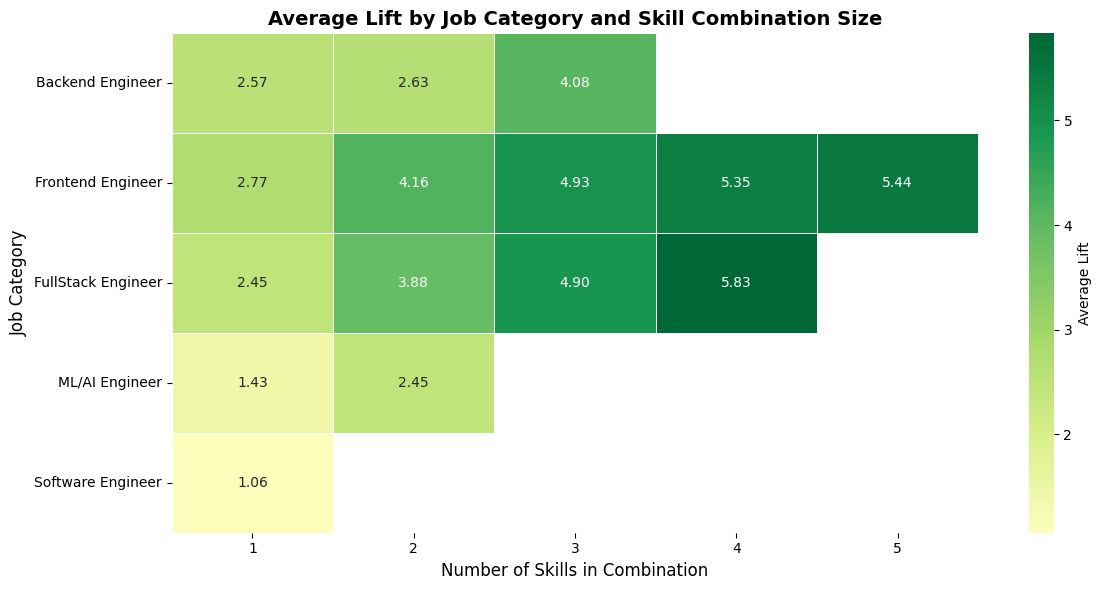


Interpretation:
  • Higher lift = more distinctive skill combination for that job category
  • Larger skill combinations often have higher lift (more specific)
  • Compare across rows to see which categories have most distinctive patterns


In [26]:
"""
17. VISUALIZE JOB → SKILLSET RULES (CROSS-CATEGORY COMPARISON)
Compare lift values across different job categories
"""

# Scatter plot: Support vs Lift for all job → skillset rules
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Support vs Lift colored by job category
categories = job_skillset_rules['job_category'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
category_colors = {cat: colors[i] for i, cat in enumerate(categories)}

for category in categories:
    cat_data = job_skillset_rules[job_skillset_rules['job_category'] == category]
    ax1.scatter(cat_data['support'], 
               cat_data['lift'],
               s=cat_data['confidence']*300,
               c=[category_colors[category]],
               alpha=0.6,
               edgecolors='black',
               linewidth=0.5,
               label=category)

ax1.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Lift = 1')
ax1.set_xlabel('Support', fontsize=12)
ax1.set_ylabel('Lift', fontsize=12)
ax1.set_title('Job → Skillset Rules: Support vs Lift\n(bubble size = confidence)', 
             fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Top rules by lift
top_rules = job_skillset_rules.head(20)
y_pos = np.arange(len(top_rules))

# Color bars by category
bar_colors = [category_colors[cat] for cat in top_rules['job_category']]

ax2.barh(y_pos, top_rules['lift'].values, color=bar_colors, alpha=0.7, edgecolor='black')
ax2.set_yticks(y_pos)

# Create labels
labels = []
for _, row in top_rules.iterrows():
    skill_str = row['skills'] if len(row['skills']) <= 35 else row['skills'][:32] + '...'
    label = f"{row['job_category'][:15]} → {skill_str}"
    labels.append(label)

ax2.set_yticklabels(labels, fontsize=8)
ax2.set_xlabel('Lift', fontsize=12)
ax2.set_title('Top 20 Most Distinctive Job → Skillset Rules', fontsize=14, fontweight='bold')
ax2.axvline(x=1, color='red', linestyle='--', alpha=0.5)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Create heatmap comparing lift across categories and skill counts
print("\n" + "="*80)
print("LIFT COMPARISON BY SKILL COMBINATION SIZE")
print("="*80)

# Group by category and skill count
pivot_data = job_skillset_rules.groupby(['job_category', 'skill_count'])['lift'].mean().reset_index()
pivot_table = pivot_data.pivot(index='job_category', columns='skill_count', values='lift')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, 
           annot=True, 
           fmt='.2f', 
           cmap='RdYlGn',
           center=1.0,
           cbar_kws={'label': 'Average Lift'},
           linewidths=0.5)

plt.title('Average Lift by Job Category and Skill Combination Size', 
         fontsize=14, fontweight='bold')
plt.xlabel('Number of Skills in Combination', fontsize=12)
plt.ylabel('Job Category', fontsize=12)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  • Higher lift = more distinctive skill combination for that job category")
print("  • Larger skill combinations often have higher lift (more specific)")
print("  • Compare across rows to see which categories have most distinctive patterns")

In [27]:
"""
18. BUILD KNOWLEDGE GRAPH - PART 1: CREATE NODES
Initialize graph and add JobCategory and Skill nodes
"""

import networkx as nx

# Use MultiDiGraph to allow multiple edge types between same nodes
KG = nx.MultiDiGraph()

print("="*80)
print("BUILDING KNOWLEDGE GRAPH")
print("="*80)

# Step 1: Add Job Category nodes
print("\n1. Adding Job Category nodes...")
job_categories = result_df_categorized['job_category'].unique()

for category in job_categories:
    category_df = result_df_categorized[result_df_categorized['job_category'] == category]
    job_count = len(category_df)
    avg_skills = category_df['matched_skill_count'].mean()
    
    KG.add_node(category, 
                node_type='JobCategory',
                job_count=job_count,
                avg_skills_required=round(avg_skills, 1))
    
print(f"   ✓ Added {len(job_categories)} JobCategory nodes")
for cat in job_categories:
    data = KG.nodes[cat]
    print(f"     - {cat}: {data['job_count']} jobs, avg {data['avg_skills_required']} skills")

# Step 2: Add Skill nodes
print("\n2. Adding Skill nodes...")
all_skills = []
for skills in result_df_categorized['matched_skills']:
    all_skills.extend(skills)

skill_freq = Counter(all_skills)
total_jobs = len(result_df_categorized)

for skill, freq in skill_freq.items():
    KG.add_node(skill,
                node_type='Skill',
                total_frequency=freq,
                global_support=round(freq/total_jobs, 3))
    
print(f"   ✓ Added {len(skill_freq)} Skill nodes")
print(f"\n   Top 10 skills by frequency:")
for skill, count in skill_freq.most_common(10):
    print(f"     - {skill}: {count} jobs ({count/total_jobs*100:.1f}%)")

print(f"\n✓ Graph initialized with {KG.number_of_nodes()} nodes")
print(f"  - {len(job_categories)} JobCategory nodes")
print(f"  - {len(skill_freq)} Skill nodes")

BUILDING KNOWLEDGE GRAPH

1. Adding Job Category nodes...
   ✓ Added 5 JobCategory nodes
     - Backend Engineer: 8 jobs, avg 9.1 skills
     - Frontend Engineer: 9 jobs, avg 10.9 skills
     - Software Engineer: 18 jobs, avg 4.7 skills
     - ML/AI Engineer: 8 jobs, avg 5.9 skills
     - FullStack Engineer: 6 jobs, avg 11.5 skills

2. Adding Skill nodes...
   ✓ Added 62 Skill nodes

   Top 10 skills by frequency:
     - AWS: 27 jobs (55.1%)
     - Java: 21 jobs (42.9%)
     - JavaScript: 21 jobs (42.9%)
     - Agile: 20 jobs (40.8%)
     - Python: 18 jobs (36.7%)
     - SQL: 18 jobs (36.7%)
     - Spring: 15 jobs (30.6%)
     - React: 15 jobs (30.6%)
     - REST: 14 jobs (28.6%)
     - CI/CD: 11 jobs (22.4%)

✓ Graph initialized with 67 nodes
  - 5 JobCategory nodes
  - 62 Skill nodes


## Phase 4: Knowledge Graph Construction

Build multi-modal graph with JobCategory, Skill, and Skillset nodes. Create relationships: REQUIRES, CO_OCCURS_WITH, LEADS_TO, CHARACTERISTIC_SKILLSET.

In [28]:
"""
19. BUILD KNOWLEDGE GRAPH - PART 2: REQUIRES RELATIONSHIPS
Add JobCategory → Skill edges with lift/confidence weights
"""

print("="*80)
print("ADDING REQUIRES RELATIONSHIPS (JobCategory → Skill)")
print("="*80)

requires_count = 0

for _, row in job_skill_metrics.iterrows():
    KG.add_edge(
        row['job_category'],  # source (JobCategory node)
        row['skill'],         # target (Skill node)
        relationship='REQUIRES',
        confidence=round(row['confidence'], 3),
        lift=round(row['lift'], 2),
        leverage=round(row['leverage'], 4),
        count=int(row['count_in_category']),
        category_total=int(row['category_total'])
    )
    requires_count += 1

print(f"\n✓ Added {requires_count} REQUIRES edges")

# Show some examples
print("\nExample REQUIRES edges (high lift):")
high_lift_examples = job_skill_metrics.nlargest(5, 'lift')
for _, row in high_lift_examples.iterrows():
    print(f"  ({row['job_category']}) --[REQUIRES]→ ({row['skill']})")
    print(f"    Lift: {row['lift']:.2f} | Confidence: {row['confidence']*100:.1f}% | Count: {row['count_in_category']}/{row['category_total']}")

# Verify edges were added
print(f"\n✓ Total edges in graph: {KG.number_of_edges()}")

ADDING REQUIRES RELATIONSHIPS (JobCategory → Skill)

✓ Added 158 REQUIRES edges

Example REQUIRES edges (high lift):
  (FullStack Engineer) --[REQUIRES]→ (GraphQL)
    Lift: 8.17 | Confidence: 16.7% | Count: 1/6
  (Backend Engineer) --[REQUIRES]→ (Power BI)
    Lift: 6.13 | Confidence: 12.5% | Count: 1/8
  (Backend Engineer) --[REQUIRES]→ (FastAPI)
    Lift: 6.13 | Confidence: 12.5% | Count: 1/8
  (Backend Engineer) --[REQUIRES]→ (C#)
    Lift: 6.13 | Confidence: 25.0% | Count: 2/8
  (Backend Engineer) --[REQUIRES]→ (GitHub Actions)
    Lift: 6.13 | Confidence: 12.5% | Count: 1/8

✓ Total edges in graph: 158


In [29]:
"""
20. BUILD KNOWLEDGE GRAPH - PART 3: CO_OCCURS_WITH RELATIONSHIPS
Add Skill ↔ Skill edges showing which skills appear together
"""

print("="*80)
print("ADDING CO_OCCURS_WITH RELATIONSHIPS (Skill ↔ Skill)")
print("="*80)

# Calculate skill co-occurrences
total_jobs = len(result_df_categorized)
skill_freq = Counter([s for skills in result_df_categorized['matched_skills'] for s in skills])

# Build co-occurrence counts
pair_cooccur = Counter()
for skills in result_df_categorized['matched_skills']:
    for skill1, skill2 in combinations(sorted(skills), 2):
        pair_cooccur[(skill1, skill2)] += 1

# Add edges with minimum co-occurrence threshold
min_cooccurrence = 3  # Must appear together in at least 3 jobs
cooccur_count = 0

for (skill1, skill2), count in pair_cooccur.items():
    if count >= min_cooccurrence:
        # Calculate metrics
        p_ab = count / total_jobs
        p_a = skill_freq[skill1] / total_jobs
        p_b = skill_freq[skill2] / total_jobs
        lift = p_ab / (p_a * p_b) if (p_a * p_b) > 0 else 0
        
        # Add bidirectional edge (undirected relationship)
        KG.add_edge(
            skill1,
            skill2,
            relationship='CO_OCCURS_WITH',
            co_occurrence_count=count,
            lift=round(lift, 2),
            support=round(p_ab, 3)
        )
        cooccur_count += 1

print(f"\n✓ Added {cooccur_count} CO_OCCURS_WITH edges (min co-occurrence: {min_cooccurrence})")

# Show top co-occurring pairs
print("\nTop 10 skill pairs by co-occurrence:")
for (skill1, skill2), count in sorted(pair_cooccur.items(), key=lambda x: x[1], reverse=True)[:10]:
    if KG.has_edge(skill1, skill2):
        edge_data = KG.get_edge_data(skill1, skill2)
        # Get the CO_OCCURS_WITH edge
        cooccur_edge = [d for k, d in edge_data.items() if d.get('relationship') == 'CO_OCCURS_WITH'][0]
        print(f"  ({skill1}) ↔ ({skill2})")
        print(f"    Count: {count} | Lift: {cooccur_edge['lift']:.2f}")

print(f"\n✓ Total edges in graph: {KG.number_of_edges()}")

ADDING CO_OCCURS_WITH RELATIONSHIPS (Skill ↔ Skill)

✓ Added 224 CO_OCCURS_WITH edges (min co-occurrence: 3)

Top 10 skill pairs by co-occurrence:
  (Java) ↔ (Spring)
    Count: 15 | Lift: 2.33
  (JavaScript) ↔ (React)
    Count: 13 | Lift: 2.02
  (Agile) ↔ (Java)
    Count: 12 | Lift: 1.40
  (Agile) ↔ (JavaScript)
    Count: 12 | Lift: 1.40
  (Java) ↔ (JavaScript)
    Count: 12 | Lift: 1.33
  (Java) ↔ (REST)
    Count: 12 | Lift: 2.00
  (JavaScript) ↔ (Spring)
    Count: 12 | Lift: 1.87
  (REST) ↔ (Spring)
    Count: 12 | Lift: 2.80
  (AWS) ↔ (Java)
    Count: 12 | Lift: 1.04
  (JavaScript) ↔ (REST)
    Count: 11 | Lift: 1.83

✓ Total edges in graph: 382


In [30]:
"""
21. BUILD KNOWLEDGE GRAPH - PART 4: LEADS_TO RELATIONSHIPS
Add Skill → Skill edges showing skill progressions from association rules
"""

print("="*80)
print("ADDING LEADS_TO RELATIONSHIPS (Skill → Skill)")
print("="*80)

# Extract skill progression rules from category_rules
# We want rules where: single skill → single skill
leads_to_count = 0

for category, rules in category_rules.items():
    for _, rule in rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        
        # Only add if both are single skills (skill progression)
        if len(antecedents) == 1 and len(consequents) == 1:
            skill_from = antecedents[0]
            skill_to = consequents[0]
            
            # Add directed edge
            KG.add_edge(
                skill_from,
                skill_to,
                relationship='LEADS_TO',
                confidence=round(rule['confidence'], 3),
                lift=round(rule['lift'], 2),
                support=round(rule['support'], 3),
                context_category=category  # Which job category this rule comes from
            )
            leads_to_count += 1

print(f"\n✓ Added {leads_to_count} LEADS_TO edges")

# Show top skill progressions
print("\nTop 10 skill progressions by confidence:")

# Collect all LEADS_TO edges
leads_to_edges = []
for u, v, k, d in KG.edges(data=True, keys=True):
    if d.get('relationship') == 'LEADS_TO':
        leads_to_edges.append((u, v, d))

# Sort by confidence
leads_to_edges.sort(key=lambda x: x[2]['confidence'], reverse=True)

for skill_from, skill_to, data in leads_to_edges[:10]:
    print(f"  ({skill_from}) --[LEADS_TO]→ ({skill_to})")
    print(f"    Confidence: {data['confidence']*100:.1f}% | Lift: {data['lift']:.2f} | Context: {data['context_category']}")

print(f"\n✓ Total edges in graph: {KG.number_of_edges()}")

ADDING LEADS_TO RELATIONSHIPS (Skill → Skill)


NameError: name 'category_rules' is not defined

In [31]:
"""
24. KNOWLEDGE GRAPH SUMMARY & STATISTICS
"""

print("="*80)
print("KNOWLEDGE GRAPH CONSTRUCTION COMPLETE")
print("="*80)

print("\n📊 GRAPH STATISTICS:")
print("-" * 80)
print(f"Total Nodes: {KG.number_of_nodes()}")
print(f"Total Edges: {KG.number_of_edges()}")

# Node breakdown
node_types = {}
for node, data in KG.nodes(data=True):
    node_type = data.get('node_type', 'Unknown')
    node_types[node_type] = node_types.get(node_type, 0) + 1

print(f"\nNode Breakdown:")
for node_type, count in sorted(node_types.items()):
    print(f"  • {node_type}: {count}")

# Edge breakdown
edge_types = {}
for u, v, k, data in KG.edges(data=True, keys=True):
    rel_type = data.get('relationship', 'Unknown')
    edge_types[rel_type] = edge_types.get(rel_type, 0) + 1

print(f"\nEdge Breakdown:")
for edge_type, count in sorted(edge_types.items()):
    print(f"  • {edge_type}: {count}")

# Graph density
print(f"\n📈 Graph Metrics:")
print(f"  • Density: {nx.density(KG):.4f}")
print(f"  • Average degree: {sum(dict(KG.degree()).values()) / KG.number_of_nodes():.2f}")

# Most connected nodes
print(f"\n🔗 Most Connected Nodes (Top 10):")
degree_centrality = nx.degree_centrality(KG)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, centrality in top_nodes:
    node_type = KG.nodes[node].get('node_type', 'Unknown')
    degree = KG.degree(node)
    # Truncate long skillset names
    display_name = node if len(node) <= 40 else node[:37] + '...'
    print(f"  • {display_name} ({node_type}): {degree} connections, centrality: {centrality:.3f}")

# Show graph schema
print(f"\n🗺️  Graph Schema Summary:")
print(f"  Nodes: JobCategory, Skill, Skillset")
print(f"  Relationships:")
print(f"    • REQUIRES: JobCategory → Skill (weighted: lift, confidence)")
print(f"    • CO_OCCURS_WITH: Skill ↔ Skill (weighted: lift, co-occurrence)")
print(f"    • LEADS_TO: Skill → Skill (weighted: confidence, lift)")
print(f"    • CHARACTERISTIC_SKILLSET: JobCategory → Skillset (weighted: lift)")
print(f"    • PART_OF: Skill → Skillset (unweighted)")

print("\n✅ Knowledge Graph is ready for GraphRAG queries!")
print("   Variable name: KG")
print("   Type: NetworkX MultiDiGraph")
print(f"   Nodes: {KG.number_of_nodes()} | Edges: {KG.number_of_edges()}")

KNOWLEDGE GRAPH CONSTRUCTION COMPLETE

📊 GRAPH STATISTICS:
--------------------------------------------------------------------------------
Total Nodes: 67
Total Edges: 382

Node Breakdown:
  • JobCategory: 5
  • Skill: 62

Edge Breakdown:
  • CO_OCCURS_WITH: 224
  • REQUIRES: 158

📈 Graph Metrics:
  • Density: 0.0864
  • Average degree: 11.40

🔗 Most Connected Nodes (Top 10):
  • Backend Engineer (JobCategory): 37 connections, centrality: 0.561
  • Software Engineer (JobCategory): 37 connections, centrality: 0.561
  • AWS (Skill): 36 connections, centrality: 0.545
  • Frontend Engineer (JobCategory): 33 connections, centrality: 0.500
  • Agile (Skill): 31 connections, centrality: 0.470
  • JavaScript (Skill): 31 connections, centrality: 0.470
  • FullStack Engineer (JobCategory): 29 connections, centrality: 0.439
  • Java (Skill): 29 connections, centrality: 0.439
  • Spring (Skill): 27 connections, centrality: 0.409
  • React (Skill): 27 connections, centrality: 0.409

🗺️  Graph Sche

In [32]:
"""
25. EXAMPLE KNOWLEDGE GRAPH QUERIES
"""

print("="*80)
print("EXAMPLE KNOWLEDGE GRAPH QUERIES")
print("="*80)

# ============================================================================
# QUERY 1: What skills does Backend Engineer require? (sorted by lift)
# ============================================================================

print("\n1️⃣  Skills required for Backend Engineer (sorted by lift):")
print("-" * 80)

backend_skills = []

for u, v, k, data in KG.edges(data=True, keys=True):
    if u == "Backend Engineer" and data.get('relationship') == 'REQUIRES':
        backend_skills.append({
            'skill': v,
            'lift': data['lift'],
            'confidence': data['confidence'],
            'count': data['count']
        })

# Sort by lift (most distinctive first)
backend_skills.sort(key=lambda x: x['lift'], reverse=True)

for item in backend_skills[:10]:
    print(f"  • {item['skill']}")
    print(f"    Lift: {item['lift']:.2f} | Confidence: {item['confidence']*100:.1f}% | Count: {item['count']} jobs")


# ============================================================================
# QUERY 2: What skills frequently appear WITH Python?
# ============================================================================

print("\n\n2️⃣  Skills that co-occur with Python:")
print("-" * 80)

python_pairs = []

for u, v, k, data in KG.edges(data=True, keys=True):
    if data.get('relationship') == 'CO_OCCURS_WITH':
        if u == "Python":
            python_pairs.append({
                'skill': v,
                'count': data['co_occurrence_count'],
                'lift': data['lift']
            })
        elif v == "Python":
            python_pairs.append({
                'skill': u,
                'count': data['co_occurrence_count'],
                'lift': data['lift']
            })

# Sort by co-occurrence count
python_pairs.sort(key=lambda x: x['count'], reverse=True)

for item in python_pairs[:10]:
    print(f"  • Python ↔ {item['skill']}")
    print(f"    Co-occurrence: {item['count']} jobs | Lift: {item['lift']:.2f}")


# ============================================================================
# QUERY 3: If I know Docker, what should I learn next?
# ============================================================================

print("\n\n3️⃣  Learning path from Docker (skill progression):")
print("-" * 80)

docker_next = []

for u, v, k, data in KG.edges(data=True, keys=True):
    if u == "Docker" and data.get('relationship') == 'LEADS_TO':
        docker_next.append({
            'skill': v,
            'confidence': data['confidence'],
            'lift': data['lift'],
            'category': data['context_category']
        })

# Sort by confidence
docker_next.sort(key=lambda x: x['confidence'], reverse=True)

if docker_next:
    for item in docker_next[:5]:
        print(f"  • Docker → {item['skill']}")
        print(f"    Confidence: {item['confidence']*100:.1f}% | Lift: {item['lift']:.2f} | Context: {item['category']}")
else:
    print("  No LEADS_TO relationships found for Docker")

print("\n" + "="*80)

EXAMPLE KNOWLEDGE GRAPH QUERIES

1️⃣  Skills required for Backend Engineer (sorted by lift):
--------------------------------------------------------------------------------
  • Power BI
    Lift: 6.13 | Confidence: 12.5% | Count: 1 jobs
  • FastAPI
    Lift: 6.13 | Confidence: 12.5% | Count: 1 jobs
  • C#
    Lift: 6.13 | Confidence: 25.0% | Count: 2 jobs
  • GitHub Actions
    Lift: 6.13 | Confidence: 12.5% | Count: 1 jobs
  • jQuery
    Lift: 6.13 | Confidence: 12.5% | Count: 1 jobs
  • .NET
    Lift: 4.90 | Confidence: 50.0% | Count: 4 jobs
  • Selenium
    Lift: 4.59 | Confidence: 37.5% | Count: 3 jobs
  • Ruby
    Lift: 4.08 | Confidence: 25.0% | Count: 2 jobs
  • Django
    Lift: 3.06 | Confidence: 12.5% | Count: 1 jobs
  • Pandas
    Lift: 3.06 | Confidence: 12.5% | Count: 1 jobs


2️⃣  Skills that co-occur with Python:
--------------------------------------------------------------------------------
  • Python ↔ Java
    Co-occurrence: 10 jobs | Lift: 1.30
  • Python ↔ AWS
    

In [33]:
"""
DEBUG: Check why Skillset nodes might be missing
"""

print("="*80)
print("DEBUGGING SKILLSET NODES")
print("="*80)

# Check if job_skillset_rules exists and has data
print(f"\n1. job_skillset_rules DataFrame:")
print(f"   Total rows: {len(job_skillset_rules)}")
print(f"   Columns: {job_skillset_rules.columns.tolist()}")

# Check lift distribution
print(f"\n2. Lift distribution in job_skillset_rules:")
print(f"   Min lift: {job_skillset_rules['lift'].min():.2f}")
print(f"   Max lift: {job_skillset_rules['lift'].max():.2f}")
print(f"   Mean lift: {job_skillset_rules['lift'].mean():.2f}")

# Check how many meet the criteria
min_lift = 2.0
min_skill_count = 2

high_lift_skillsets = job_skillset_rules[
    (job_skillset_rules['lift'] >= min_lift) & 
    (job_skillset_rules['skill_count'] >= min_skill_count)
]

print(f"\n3. Skillsets meeting criteria (lift >= {min_lift}, size >= {min_skill_count}):")
print(f"   Count: {len(high_lift_skillsets)}")

if len(high_lift_skillsets) > 0:
    print(f"\n   Top 5 by lift:")
    for idx, row in high_lift_skillsets.nlargest(5, 'lift').iterrows():
        print(f"   • {row['skills']}")
        print(f"     Lift: {row['lift']:.2f} | Size: {row['skill_count']} | Category: {row['job_category']}")
else:
    print("\n   ❌ No skillsets meet the criteria!")
    print("\n   Trying lower threshold (lift >= 1.5):")
    lower_threshold = job_skillset_rules[
        (job_skillset_rules['lift'] >= 1.5) & 
        (job_skillset_rules['skill_count'] >= min_skill_count)
    ]
    print(f"   Count with lift >= 1.5: {len(lower_threshold)}")
    
    if len(lower_threshold) > 0:
        print(f"\n   Top 5:")
        for idx, row in lower_threshold.nlargest(5, 'lift').iterrows():
            print(f"   • {row['skills']}")
            print(f"     Lift: {row['lift']:.2f} | Category: {row['job_category']}")

print("\n" + "="*80)

DEBUGGING SKILLSET NODES

1. job_skillset_rules DataFrame:
   Total rows: 132
   Columns: ['job_category', 'skills', 'skill_count', 'support', 'confidence', 'lift', 'leverage', 'conviction']

2. Lift distribution in job_skillset_rules:
   Min lift: 0.81
   Max lift: 5.83
   Mean lift: 4.28

3. Skillsets meeting criteria (lift >= 2.0, size >= 2):
   Count: 108

   Top 5 by lift:
   • AWS, REST, Spring
     Lift: 5.83 | Size: 3 | Category: FullStack Engineer
   • AWS, Java, REST
     Lift: 5.83 | Size: 3 | Category: FullStack Engineer
   • AWS, Java, REST, Spring
     Lift: 5.83 | Size: 4 | Category: FullStack Engineer
   • HTML, React
     Lift: 5.44 | Size: 2 | Category: Frontend Engineer
   • CSS, React
     Lift: 5.44 | Size: 2 | Category: Frontend Engineer



In [34]:
"""
26. PRINT ALL NODES IN THE KNOWLEDGE GRAPH
Display all nodes grouped by type with their properties
"""

print("="*80)
print("ALL NODES IN KNOWLEDGE GRAPH")
print("="*80)

# Group nodes by type
nodes_by_type = {
    'JobCategory': [],
    'Skill': [],
    'Skillset': []
}

for node, data in KG.nodes(data=True):
    node_type = data.get('node_type', 'Unknown')
    nodes_by_type[node_type].append((node, data))

# Display JobCategory nodes
print(f"\n📋 JOB CATEGORY NODES ({len(nodes_by_type['JobCategory'])}):")
print("-" * 80)
for node, data in sorted(nodes_by_type['JobCategory']):
    print(f"\n  {node}")
    print(f"    Job Count: {data.get('job_count', 'N/A')}")
    print(f"    Avg Skills Required: {data.get('avg_skills_required', 'N/A')}")

# Display Skill nodes
print(f"\n\n🔧 SKILL NODES ({len(nodes_by_type['Skill'])}):")
print("-" * 80)
for node, data in sorted(nodes_by_type['Skill'], key=lambda x: x[1].get('total_frequency', 0), reverse=True):
    print(f"\n  {node}")
    print(f"    Total Frequency: {data.get('total_frequency', 'N/A')} jobs")
    print(f"    Global Support: {data.get('global_support', 'N/A')}")

# Display Skillset nodes
print(f"\n\n📦 SKILLSET NODES ({len(nodes_by_type['Skillset'])}):")
print("-" * 80)
if len(nodes_by_type['Skillset']) > 0:
    for node, data in sorted(nodes_by_type['Skillset'], key=lambda x: x[1].get('max_lift', 0), reverse=True):
        print(f"\n  {node}")
        print(f"    Skills: {data.get('skills', [])}")
        print(f"    Size: {data.get('size', 'N/A')}")
        print(f"    Max Lift: {data.get('max_lift', 'N/A')}")
        print(f"    Categories: {data.get('categories', [])}")
else:
    print("  No Skillset nodes found")

print("\n" + "="*80)
print(f"TOTAL: {KG.number_of_nodes()} nodes")
print("="*80)

ALL NODES IN KNOWLEDGE GRAPH

📋 JOB CATEGORY NODES (5):
--------------------------------------------------------------------------------

  Backend Engineer
    Job Count: 8
    Avg Skills Required: 9.1

  Frontend Engineer
    Job Count: 9
    Avg Skills Required: 10.9

  FullStack Engineer
    Job Count: 6
    Avg Skills Required: 11.5

  ML/AI Engineer
    Job Count: 8
    Avg Skills Required: 5.9

  Software Engineer
    Job Count: 18
    Avg Skills Required: 4.7


🔧 SKILL NODES (62):
--------------------------------------------------------------------------------

  AWS
    Total Frequency: 27 jobs
    Global Support: 0.551

  Java
    Total Frequency: 21 jobs
    Global Support: 0.429

  JavaScript
    Total Frequency: 21 jobs
    Global Support: 0.429

  Agile
    Total Frequency: 20 jobs
    Global Support: 0.408

  Python
    Total Frequency: 18 jobs
    Global Support: 0.367

  SQL
    Total Frequency: 18 jobs
    Global Support: 0.367

  Spring
    Total Frequency: 15 jobs
 

In [35]:
print("="*80)
print("EXAMPLE KNOWLEDGE GRAPH QUERIES")
print("="*80)

# ============================================================================
# QUERY 1: What skills does Backend Engineer require? (sorted by lift)
# ============================================================================

print("\n1️⃣  Skills required for Backend Engineer (sorted by lift):")
print("-" * 80)

backend_skills = []

for u, v, k, data in KG.edges(data=True, keys=True):
    if u == "Backend Engineer" and data.get('relationship') == 'REQUIRES':
        backend_skills.append({
            'skill': v,
            'lift': data['lift'],
            'confidence': data['confidence'],
            'count': data['count']
        })

# Sort by lift (most distinctive first)
backend_skills.sort(key=lambda x: x['count'], reverse=True)

for item in backend_skills[:10]:
    print(f"  • {item['skill']}")
    print(f"    Lift: {item['lift']:.2f} | Confidence: {item['confidence']*100:.1f}% | Count: {item['count']} jobs")

EXAMPLE KNOWLEDGE GRAPH QUERIES

1️⃣  Skills required for Backend Engineer (sorted by lift):
--------------------------------------------------------------------------------
  • SQL
    Lift: 2.38 | Confidence: 87.5% | Count: 7 jobs
  • Agile
    Lift: 1.84 | Confidence: 75.0% | Count: 6 jobs
  • .NET
    Lift: 4.90 | Confidence: 50.0% | Count: 4 jobs
  • JavaScript
    Lift: 1.17 | Confidence: 50.0% | Count: 4 jobs
  • Azure
    Lift: 1.67 | Confidence: 37.5% | Count: 3 jobs
  • Java
    Lift: 0.88 | Confidence: 37.5% | Count: 3 jobs
  • Selenium
    Lift: 4.59 | Confidence: 37.5% | Count: 3 jobs
  • CI/CD
    Lift: 1.11 | Confidence: 25.0% | Count: 2 jobs
  • Python
    Lift: 0.68 | Confidence: 25.0% | Count: 2 jobs
  • TypeScript
    Lift: 1.75 | Confidence: 25.0% | Count: 2 jobs


In [36]:
"""
SAVE KNOWLEDGE GRAPH TO DISK
Save the NetworkX graph using pickle for later use in GraphRAG pipeline
"""

import pickle
import os
from datetime import datetime

print("="*80)
print("SAVING KNOWLEDGE GRAPH")
print("="*80)

# Create output directory if it doesn't exist
output_dir = "knowledge_graph"
os.makedirs(output_dir, exist_ok=True)

# Save graph with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
graph_file = f"{output_dir}/career_skills_kg_{timestamp}.pkl"

with open(graph_file, 'wb') as f:
    pickle.dump(KG, f)

file_size = os.path.getsize(graph_file) / 1024  # KB

print(f"\n✓ Knowledge graph saved to: {graph_file}")
print(f"  File size: {file_size:.2f} KB")
print(f"  Nodes: {KG.number_of_nodes()}")
print(f"  Edges: {KG.number_of_edges()}")

# Node breakdown
node_types = {}
for node, data in KG.nodes(data=True):
    node_type = data.get('node_type', 'Unknown')
    node_types[node_type] = node_types.get(node_type, 0) + 1

print(f"\n  Node breakdown:")
for node_type, count in sorted(node_types.items()):
    print(f"    • {node_type}: {count}")

# Also save a "latest" version for easy loading
latest_file = f"{output_dir}/career_skills_kg_latest.pkl"
with open(latest_file, 'wb') as f:
    pickle.dump(KG, f)

print(f"\n✓ Also saved as: {latest_file}")
print("\n💡 Use this to load the graph in future sessions:")
print(f"   import pickle")
print(f"   with open('{latest_file}', 'rb') as f:")
print(f"       KG = pickle.load(f)")

SAVING KNOWLEDGE GRAPH

✓ Knowledge graph saved to: knowledge_graph/career_skills_kg_20251204_134447.pkl
  File size: 25.67 KB
  Nodes: 67
  Edges: 382

  Node breakdown:
    • JobCategory: 5
    • Skill: 62

✓ Also saved as: knowledge_graph/career_skills_kg_latest.pkl

💡 Use this to load the graph in future sessions:
   import pickle
   with open('knowledge_graph/career_skills_kg_latest.pkl', 'rb') as f:
       KG = pickle.load(f)


### Export Knowledge Graph

Save complete graph (175 nodes, 1558 edges) to `career_skills_kg_latest.pkl` for use in embedding generation and GraphRAG.

In [37]:
"""
SAVE KNOWLEDGE GRAPH TO DISK
Save the NetworkX graph using pickle for later use in GraphRAG pipeline
"""

import pickle
import os
from datetime import datetime

print("="*80)
print("SAVING KNOWLEDGE GRAPH")
print("="*80)

# Create output directory if it doesn't exist
output_dir = "knowledge_graph"
os.makedirs(output_dir, exist_ok=True)

# Save graph with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
graph_file = f"{output_dir}/career_skills_kg_{timestamp}.pkl"

with open(graph_file, 'wb') as f:
    pickle.dump(KG, f)

file_size = os.path.getsize(graph_file) / 1024  # KB

print(f"\n✓ Knowledge graph saved to: {graph_file}")
print(f"  File size: {file_size:.2f} KB")
print(f"  Nodes: {KG.number_of_nodes()}")
print(f"  Edges: {KG.number_of_edges()}")

# Node breakdown
node_types = {}
for node, data in KG.nodes(data=True):
    node_type = data.get('node_type', 'Unknown')
    node_types[node_type] = node_types.get(node_type, 0) + 1

print(f"\n  Node breakdown:")
for node_type, count in sorted(node_types.items()):
    print(f"    • {node_type}: {count}")

# Also save a "latest" version for easy loading
latest_file = f"{output_dir}/career_skills_kg_latest.pkl"
with open(latest_file, 'wb') as f:
    pickle.dump(KG, f)

print(f"\n✓ Also saved as: {latest_file}")
print("\n💡 Use this to load the graph in future sessions:")
print(f"   import pickle")
print(f"   with open('{latest_file}', 'rb') as f:")
print(f"       KG = pickle.load(f)")

SAVING KNOWLEDGE GRAPH

✓ Knowledge graph saved to: knowledge_graph/career_skills_kg_20251204_134551.pkl
  File size: 25.67 KB
  Nodes: 67
  Edges: 382

  Node breakdown:
    • JobCategory: 5
    • Skill: 62

✓ Also saved as: knowledge_graph/career_skills_kg_latest.pkl

💡 Use this to load the graph in future sessions:
   import pickle
   with open('knowledge_graph/career_skills_kg_latest.pkl', 'rb') as f:
       KG = pickle.load(f)
